### Импортируем необходимые модули

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
from tqdm import tqdm
import time
import pickle

sns.set_style('darkgrid')
%matplotlib inline

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
from pymorphy2 import MorphAnalyzer
from navec import Navec

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.model_selection import PredefinedSplit, StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_auc_score, precision_recall_curve as pr_curve
from sklearn.metrics import auc, fbeta_score, make_scorer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

In [4]:
df = pd.read_csv('wb_school_task_2.csv.gzip', compression='gzip')

In [5]:
df.head()

id1                   id2                   id3  \
0   7596126584852021591    173777575861152844  18254136755182295358   
1   5327406586753254371  14366783259208998381   2324030737335224220   
2   2636757786779776109  16985421652518589249   4904562693381133981   
3  15432976385014516263   2629180387521298831  13541353053200353836   
4  11933982800034911890  14531191561111600318   9121890650636487522   

                                                text  f1  f2   f3   f4  f5  \
0  Хотела купить на замену старых,по итогу эти  у...   1   1  1.0   11  13   
1  Запах по сравнению с обычным DOVE никакой. Оно...  10   6  2.7   46   4   
2                   Кабель подошёл, хорошо работает.   4   4  4.0   14   0   
3  Восторг! Очень приятный аромат, держится долго...   6   6  5.0  374  30   
4  Визуально все хорошо. Не пробовали. Купили в п...  19  18  5.0    6   4   

         f6  f7   f8  label  
0  4.272727  18   36      0  
1  4.434783  90  109      1  
2  4.500000   4    6      0  
3  4.772727  14   15      1  
4  5.000000  26   33      0

## L0. Формализация задачи и определение таргета

* **Формализация задачи:**  
Задача бинарной классификации  
  
* **Целевая переменная:**  
Таргет (столбец "label") - является ли отзыв фейковым. 1 - отзыв фейковый, 0 - отзыв настоящий  
  
* **Метрики:**
    1. Accuracy. Как будет показано далее в разделе, который посвящен EDA, имеет место серьезный дисбаланс классов, поэтому в данном случае метрику accuracy использовать не будем
    2. Precision и Recall. Если мы будем пытаться максимизировать только точность (Precision), не обращая внимание на полноту (Recall), то в ситуации, если мы получим высокую точность и низкую полноту, получится, что наша модель корректно относит отзывы к фейковым, но при этом мы выявляем далеко не все фейковые отзывы (из-за низкой полноты), что, скорее всего, с точки зрения бизнеса плохо. Рассмотрим теперь противоположную ситуацию: мы фокусируемся только на Recall и наша модель имеет высокую полноту и низкую точность, тогда получится, что модели удается выявить бОльшую часть фейковых отзывов, но при этом модель часть настоящих отзывов отнесла к фейковым, что опять же нехорошо с точки зрения бизнеса.
    3. F-мера. F-мера объединяет точность и полноту, поэтому в качестве основной метрики выберем её.

In [6]:
df.label.unique()

array([0, 1], dtype=int64)

In [7]:
real_sample = df[df.label == 0].text.head(7).to_list()
for i, s in enumerate(real_sample):
    print(i + 1, s)

1 Хотела купить на замену старых,по итогу эти  ужаснотупые ,не удобные ,рвут кутикулу ,а не режут.
2 Кабель подошёл, хорошо работает.
3 Визуально все хорошо. Не пробовали. Купили в подарок
4 Коробка в состоянии,, прошла Афган,,! Гладкая кожа носков сапог тоже уже не выглядит новой. Но сапоги вернула совсем не по этим причинам. Дело в том, что всамой модели сапог странное голенище. Дизайнер просчитался, решил вставить в эскиз замок, хотя стоило обойтись резинкой, дающей возможность вместить любую толщину икры женской ножки. Замок топорщит, держит странную форму, что портит вид сапог.
5 Джинсы хорошие качество отличное но дороговаты и Малы очень  брал на два размера больше но увы так что возврат
6 Камеры не закрывает, камеры в ровень с чехлом
7 Юлия не могли бы Вы проверить стеганку которую я вернула нет ли в карманах ключ от машин, я боюсь что в примерочной я по инерции их положила в карман и вернула позвони если есть по этому номеру 287896096


In [8]:
fake_sample = df[df.label == 1].text.head(7).to_list()
for i, s in enumerate(fake_sample):
    print(i + 1, s)

1 Запах по сравнению с обычным DOVE никакой. Оно не парфюмированное. Только баночки симпатичные и всё
2 Восторг! Очень приятный аромат, держится долго, очень удобный формат для сумочки.
3 Хорошее качество
4 Хорошо упакован, Оригенал 👌🏻спасибо
5 Оыоырыгыоцрцныоцн
6 Доставка-скорость света! Отличная ёмкость, кажется большеватой. НО! под любой стик мыла и пена остаётся внутри и не нужно собирать снаружи. Крышка садится не туго и не болтается. Транспортная упаковка надёжная. Всё без повреждений.
7 Здравствуйте! Товар получила, покупала подарок детям, нам очень понравилась. Соответствует как в картинки рисунки все аккуратно ни какого брака нет, фиксаторы даже запасом есть все отлично👍👍👍👍 спасибо большое за быструю сборку продавцу💐💐💐. И спасибо производителю💋💋💋


## L1. Первичный анализ данных (EDA)

### Посмотрим количество строк и общую информацию

In [9]:
print(f'Датафрейм содержит {df.shape[0]} строк и {df.shape[1]} колонок')

Датафрейм содержит 3123 строк и 13 колонок


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123 entries, 0 to 3122
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id1     3123 non-null   uint64 
 1   id2     3123 non-null   uint64 
 2   id3     3123 non-null   uint64 
 3   text    3123 non-null   object 
 4   f1      3123 non-null   int64  
 5   f2      3123 non-null   int64  
 6   f3      3123 non-null   float64
 7   f4      3123 non-null   int64  
 8   f5      3123 non-null   int64  
 9   f6      3123 non-null   float64
 10  f7      3123 non-null   int64  
 11  f8      3123 non-null   int64  
 12  label   3123 non-null   int64  
dtypes: float64(2), int64(7), object(1), uint64(3)
memory usage: 317.3+ KB


### Обработка пропусков

In [11]:
df.isna().sum()

id1      0
id2      0
id3      0
text     0
f1       0
f2       0
f3       0
f4       0
f5       0
f6       0
f7       0
f8       0
label    0
dtype: int64

Пропусков (в виде NaN'ов) в таблице нет, но стоит проверить, нет ли в столбце "text" пустых (или например, состоящих только из пробелов) строчек

In [12]:
df[(df.text.str.split().str.len() == 0)]

Empty DataFrame
Columns: [id1, id2, id3, text, f1, f2, f3, f4, f5, f6, f7, f8, label]
Index: []

Таких пустых строк нет, но есть другая особенность. Взглянем на текст отзыва с индексом 23 из датафрейма

In [13]:
df.loc[23].text

'︎ ︎ ︎ ︎ ︎ ︎'

In [14]:
ord(df.loc[23].text[0])

65038

Визуально кажется, что это строчка из пробелов, но на самом деле она состоит из пробелов, чередующихся с [каким-то непонятным символом unicode](https://symbl.cc/ru/search/?q=65038)

Также обнаружил строку только из нижних подчеркиваний.

In [15]:
df.loc[408].text

'__________'

Эти ситуации будем обрабатывать далее, когда будем выполнять препроцессинг строк

### Проанализируем баланс классов

In [16]:
balance = df.label.value_counts() 
print(f'Выборка содержит {balance.loc[0]} реальных и {balance.loc[1]} фейковых отзывов')

Выборка содержит 2298 реальных и 825 фейковых отзывов


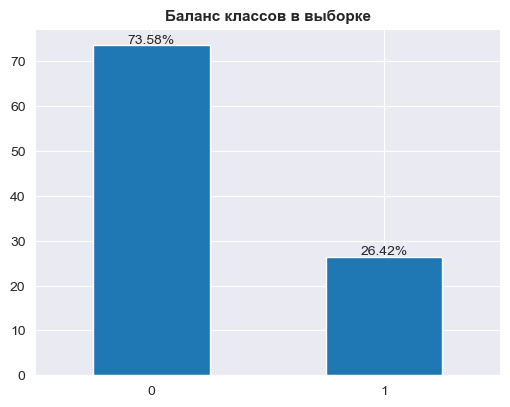

In [17]:
balance = balance * 100 / balance.sum()
ax = balance.plot(kind='bar', figsize=(6, 4.5))
plt.title('Баланс классов в выборке', fontsize=11, weight='bold')
plt.xticks(rotation=0)
for i in balance.index:
    plt.text(i, balance.loc[i] + 0.5, str(round(balance.loc[i], 2)) + '%', ha='center')
plt.show()

**Явный дисбаланс (в выборке преобладают реальные отзывы)**

### Подумаем, что означают прочие столбцы и проанализируем их

**Начнем со столбцов, которые содержат id**

In [18]:
id_cols = ['id1', 'id2', 'id3']
for col in id_cols:
    print(f'Уникальных значений в колонке {col} : {df[col].nunique()} / {len(df)}')

Уникальных значений в колонке id1 : 3049 / 3123
Уникальных значений в колонке id2 : 3006 / 3123
Уникальных значений в колонке id3 : 978 / 3123


переменная "id1" содержит id пользователя, "id2" - id товара?, "id3" содержит id продавца?  
Вывод сделан после просмотра глазами отзывов с одинаковыми айдишниками. Например, для id1 было местами заметно, что пишет один и тот же человек (некоторые отзывы с одинаковым id начинались одинаково), также кажется, что уникальных пользователей, скорее всего, должно быть больше, чем уникальных товаров и продавцов (см. ячейку выше).

**Перейдем к числовым фичам**

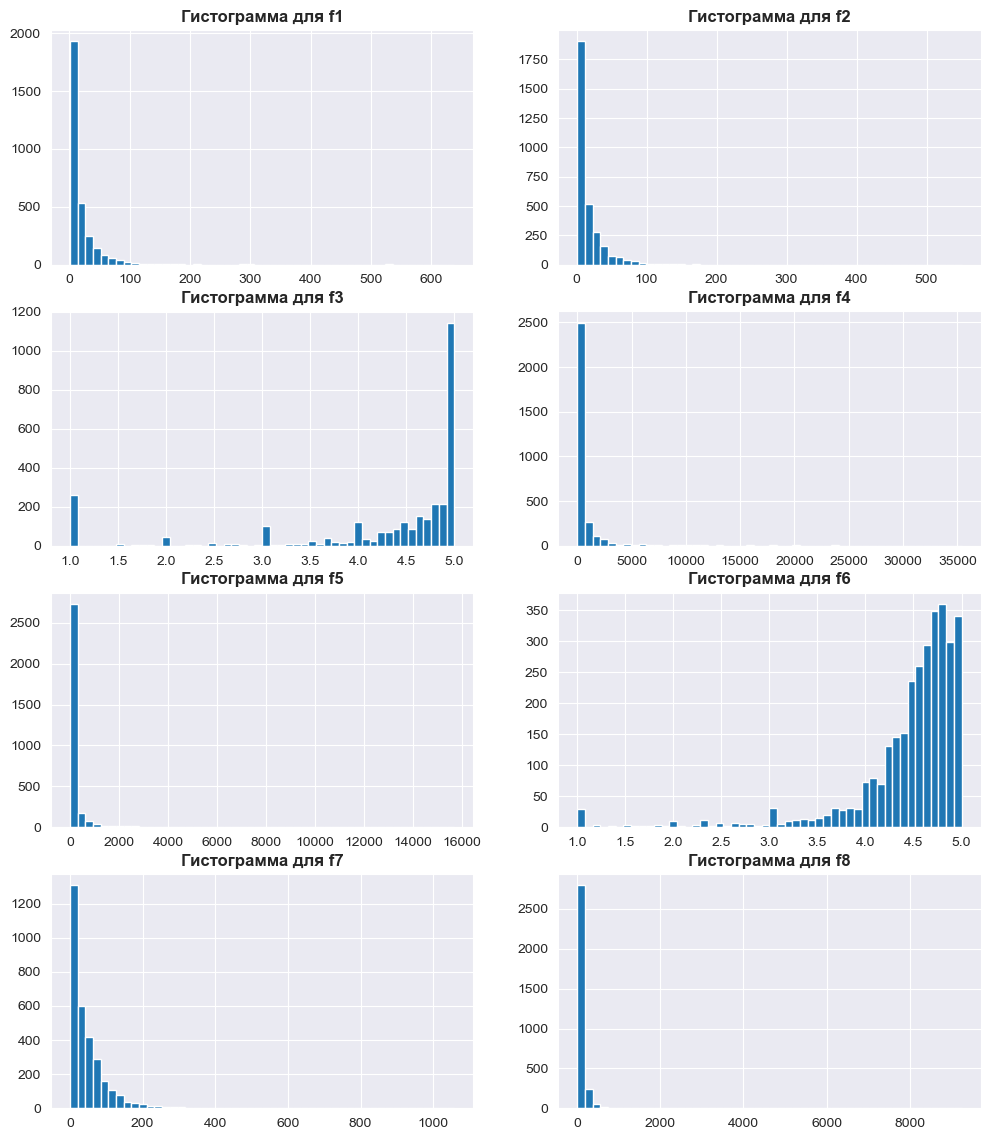

In [19]:
f_cols = ['f' + str(i) for i in range(1, 9)]
plt_arr = np.reshape(f_cols, (4, 2))

fig, axs = plt.subplots(4, 2, figsize=(12, 14))
for i in range(4):
    for j in range(2):
        cur_col = plt_arr[i][j]
        df[cur_col].hist(ax=axs[i][j], bins=50)
        axs[i][j].set_title(f'Гистограмма для {cur_col}', weight='bold')
plt.show()

По гистограммам видно, что для всех переменных, кроме f3 и f6 присутствуют существенные выбросы

Выдвинем предположение о том, что за информация хранится в числовых признаках f1-f8
* f3 - средняя оценка пользователя?
* f6 - средняя оценка товара/продавца?
* f1, f2, f4, f5, f7, f8 - int'ы, возможно, что-то из этого отражает общее количество отзывов у пользователя/товара/продавца  
  
Гипотеза 1: если id1 действительно содержит id пользователя, как я предположил выше, то, скорее всего, фичи f1, f2, f3, f7, f8 содержат какую-то информацию о пользователе, потому что для каждого отдельно взятого значения id1 значения этих признаков не меняются, проверить можно с помощью кода ниже.  
Гипотеза 2: если id2 действительно содержит id товара, как я предположил выше, то, скорее всего, переменная f6 это все-таки средняя оценка товара, а переменные f4, f5 это какие-то другие характеристики товаров (определил, используя аналогичную логику, что и для гипотезы 1, код приведен ниже)

In [20]:
# df.id1.nunique() == df[['id1', 'f1', 'f2', 'f3', 'f7', 'f8']].drop_duplicates().shape[0]

In [36]:
# df[['id2', 'f4', 'f5', 'f6']][df['id2'].duplicated(keep=False)].drop_duplicates().shape[0] == df[df['id2'].duplicated(keep=False)].id2.nunique()

**Взглянем на описательные статистики**

In [20]:
df.loc[:, 'f1':].describe()

f1           f2           f3            f4            f5  \
count  3123.000000  3123.000000  3123.000000   3123.000000   3123.000000   
mean     19.409862    16.216459     4.232658    808.603586    216.628562   
std      35.746560    26.070112     1.179999   2509.350075    802.154201   
min       1.000000     1.000000     1.000000      1.000000      0.000000   
25%       2.000000     2.000000     4.076923     26.000000      6.000000   
50%       8.000000     7.000000     4.764706    116.000000     26.000000   
75%      23.000000    20.000000     5.000000    493.000000    110.000000   
max     638.000000   550.000000     5.000000  35375.000000  15683.000000   

                f6           f7           f8        label  
count  3123.000000  3123.000000  3123.000000  3123.000000  
mean      4.453445    48.155620    94.356708     0.264169  
std       0.619495    67.107753   329.525613     0.440960  
min       1.000000     0.000000     1.000000     0.000000  
25%       4.331071     8.000000    13.000000     0.000000  
50%       4.617978    30.000000    45.000000     0.000000  
75%       4.809556    65.000000   107.000000     1.000000  
max       5.000000  1058.000000  9243.000000     1.000000

**Корреляции**

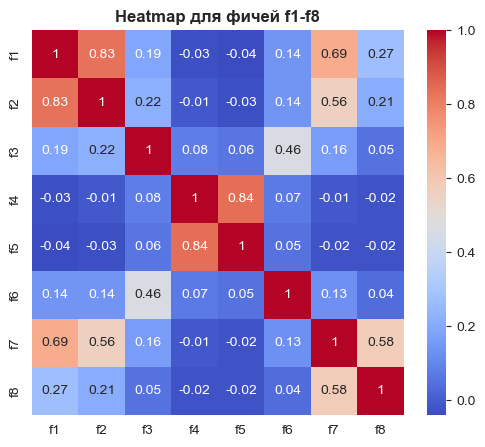

In [21]:
fig = plt.figure(figsize=(6, 5))
sns.heatmap(df[f_cols].corr().round(2), annot=True, cmap='coolwarm')
plt.title('Heatmap для фичей f1-f8', weight='bold')
plt.show()

Как видим, пары переменных f1-f2 и f4-f5 имеют достаточно сильную корреляцию

### Добавим и проанализируем новые признаки

In [22]:
def avg_word_len(s):
    return np.mean(list(map(len, word_tokenize(s, language='russian'))))


def avg_sent_len(s):
    return np.mean(list(map(len, sent_tokenize(s, language='russian'))))


def caps_portion(s, text_len):
    l = re.findall('[А-ЯA-Z]+', s)
    return sum(map(len, l)) / text_len


def punct_portion(s, text_len):
    l = re.findall(r'[!"#$%&\'()*+,-./:;<=>?@\\^_`{|}~]+', s)
    return sum(map(len, l)) / text_len

* text_len - символьная длина отзыва;
* word_count - количество слов в отзыве;
* sent_count - количество предложений в отзыве;
* avg_word_len - средняя длина слова;
* avg_sent_len - средняя длина предложения;
* caps_portion - доля капса;
* punct_portion - доля знаков пунктуации.

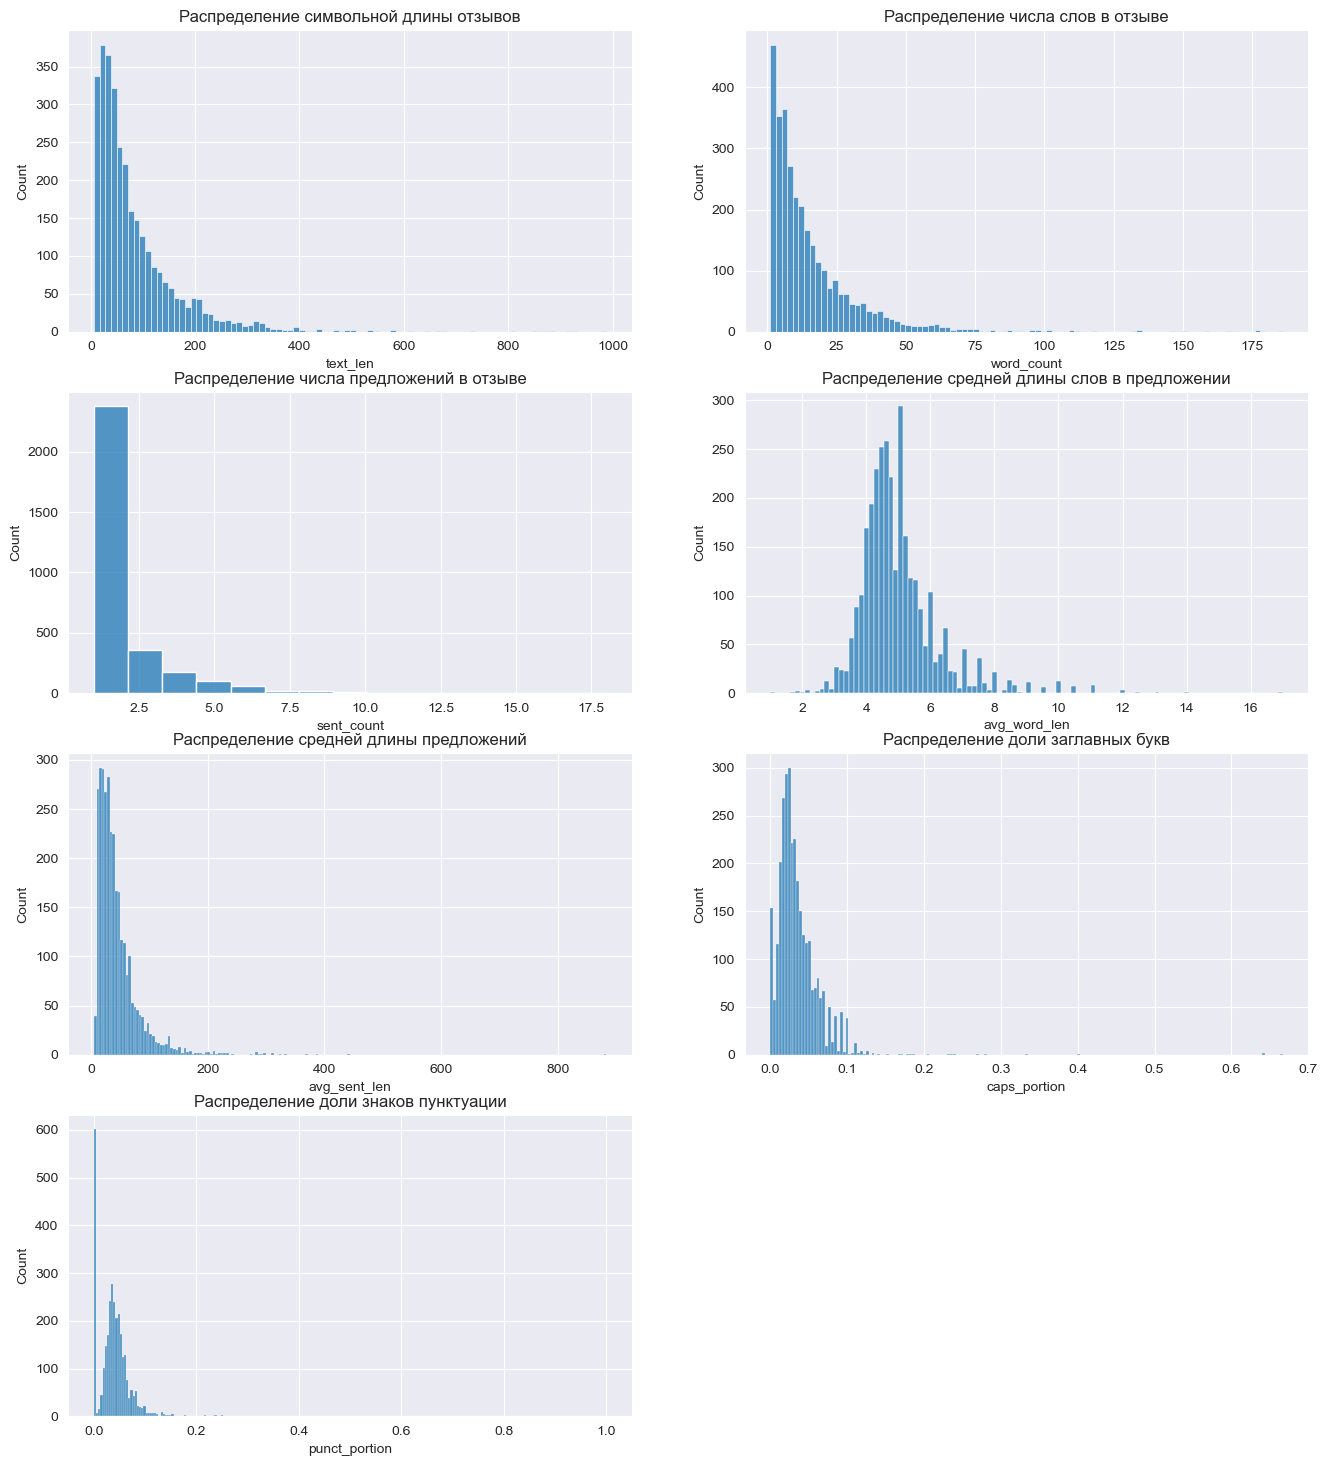

In [23]:
df['text_len'] = df.text.str.len()
df['word_count'] = df.text.apply(lambda x: len(word_tokenize(x, language='russian')))
df['sent_count'] = df.text.apply(lambda x: len(sent_tokenize(x, language='russian')))
df['avg_word_len'] = df.text.apply(avg_word_len)
df['avg_sent_len'] = df.text.apply(avg_sent_len)
df['caps_portion'] = df.apply(lambda x: caps_portion(x.text, x.text_len), axis=1) 
df['punct_portion'] = df.apply(lambda x: punct_portion(x.text, x.text_len), axis=1)
df['f9'] = df['f5'] / df['f4'] 
df['f10'] = df['f2'] / df['f1']

fig, ax = plt.subplots(4, 2, figsize=(16, 18))
sns.histplot(data=df.text_len, ax=ax[0][0])
ax[0][0].set_title('Распределение символьной длины отзывов')

sns.histplot(data=df.word_count, ax=ax[0][1])
ax[0][1].set_title('Распределение числа слов в отзыве')

sns.histplot(data=df.sent_count, ax=ax[1][0], bins=15)
ax[1][0].set_title('Распределение числа предложений в отзыве')

sns.histplot(data=df.avg_word_len, ax=ax[1][1])
ax[1][1].set_title('Распределение средней длины слов в предложении')

sns.histplot(data=df.avg_sent_len, ax=ax[2][0])
ax[2][0].set_title('Распределение средней длины предложений')

sns.histplot(data=df.caps_portion, ax=ax[2][1])
ax[2][1].set_title('Распределение доли заглавных букв')

sns.histplot(data=df.punct_portion, ax=ax[3][0])
ax[3][0].set_title('Распределение доли знаков пунктуации')

ax[3][1].axis('off')

plt.show()

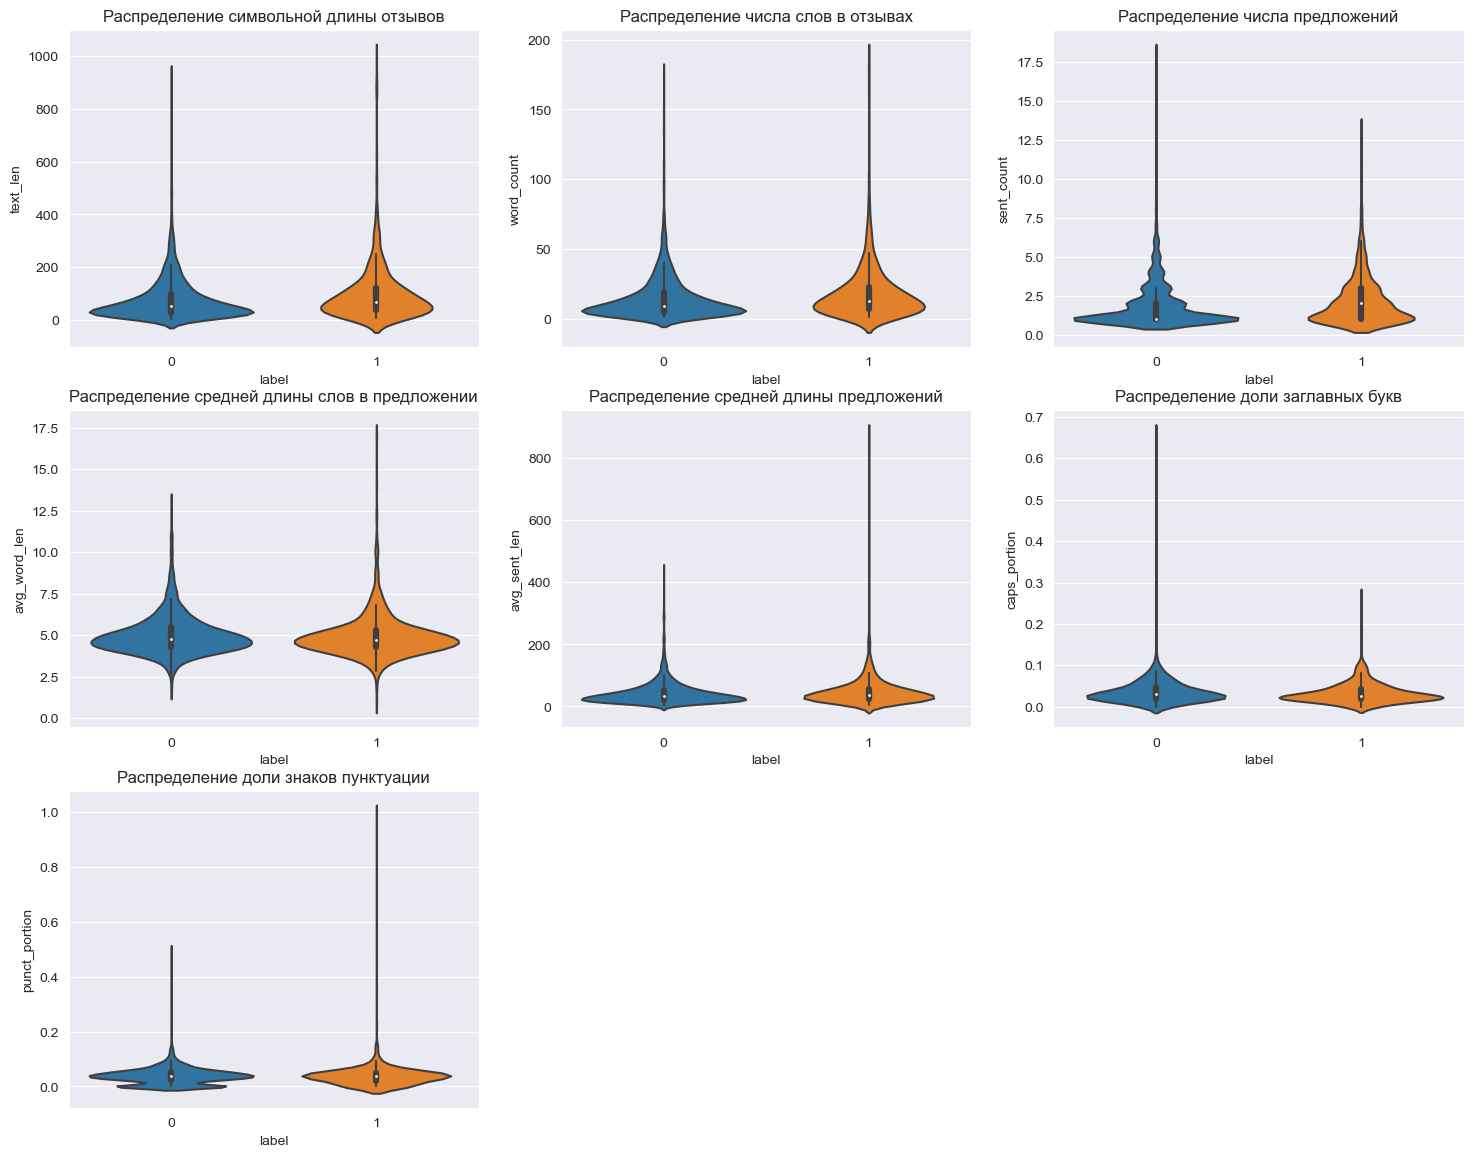

In [24]:
fig, ax = plt.subplots(3, 3, figsize=(18, 14))
sns.violinplot(data=df, x='label', y='text_len', ax=ax[0][0])
ax[0][0].set_title('Распределение символьной длины отзывов')

sns.violinplot(data=df, x='label', y='word_count', ax=ax[0][1])
ax[0][1].set_title('Распределение числа слов в отзывах')

sns.violinplot(data=df, x='label', y='sent_count', ax=ax[0][2], bins=15)
ax[0][2].set_title('Распределение числа предложений')

sns.violinplot(data=df, x='label', y='avg_word_len', ax=ax[1][0])
ax[1][0].set_title('Распределение средней длины слов в предложении')

sns.violinplot(data=df, x='label', y='avg_sent_len', ax=ax[1][1])
ax[1][1].set_title('Распределение средней длины предложений')

sns.violinplot(data=df, x='label', y='caps_portion', ax=ax[1][2])
ax[1][2].set_title('Распределение доли заглавных букв')

sns.violinplot(data=df, x='label', y='punct_portion', ax=ax[2][0])
ax[2][0].set_title('Распределение доли знаков пунктуации')

ax[2][1].axis('off')
ax[2][2].axis('off')

plt.show()

### Определим наличие дубликатов

In [25]:
df.text.describe()

count               3123
unique              3078
top       Отличный товар
freq                  11
Name: text, dtype: object

Тексты отзывов не являются уникальными

Небольшое замечание: заметил, что для самого частовстречаемого текста ("Отличный товар") в 2 случаях из 11 отзывы являются фейковыми, также видел несколько отзывов, которые состояли только из смайликов с большими пальцами, но они тоже имели разные метки, соответственно, можно сделать вывод, что текст отзыва, скорее всего, не является определяющим фактором того, вляется ли отзыв фейковым, поэтому нужно учитывать остальные фичи.

**Проверим, есть ли полные дубликаты (т.е. полное совпадение строк датафрейма)**

In [26]:
df[df.duplicated(keep=False)]

id1                   id2                  id3  \
45  3231785663555852656  15727904128262950318  3260081402716394163   
46  3231785663555852656  15727904128262950318  3260081402716394163   

                                                 text   f1  f2       f3  f4  \
45  Замечательные, легкие,красивые! На свой 38, вз...  127  87  4.80315  10   
46  Замечательные, легкие,красивые! На свой 38, вз...  127  87  4.80315  10   

    f5   f6  ...  label  text_len  word_count  sent_count  avg_word_len  \
45   3  5.0  ...      0       136          29           5      4.103448   
46   3  5.0  ...      0       136          29           5      4.103448   

    avg_sent_len  caps_portion  punct_portion   f9       f10  
45          26.4      0.036765       0.073529  0.3  0.685039  
46          26.4      0.036765       0.073529  0.3  0.685039  

[2 rows x 22 columns]

Удалим вторую из двух совпадающих строчек

In [27]:
df = df.drop_duplicates()

Также есть два наблюдения, где один и тот же пользователь написал одинаковый текст для разных товаров одного продавца. Кажется, что удалять смысла не имеет.

In [28]:
df[df[['id1', 'text']].duplicated(keep=False)]

id1                   id2                  id3  \
2797  3884959853494955383   2378932839265966503  9034398454034589390   
2831  3884959853494955383  12021259612890125721  9034398454034589390   

                  text  f1  f2        f3   f4  f5        f6  ...  label  \
2797  Внукам нравится!  44  31  4.909091  174  20  4.919540  ...      0   
2831  Внукам нравится!  44  31  4.909091  490  55  4.804082  ...      0   

      text_len  word_count  sent_count  avg_word_len  avg_sent_len  \
2797        16           3           1           5.0          16.0   
2831        16           3           1           5.0          16.0   

      caps_portion  punct_portion        f9       f10  
2797        0.0625         0.0625  0.114943  0.704545  
2831        0.0625         0.0625  0.112245  0.704545  

[2 rows x 22 columns]

Проверим, нет ли ситуации, когда один пользователь оставил более одного отзыва какому-то товару.

In [29]:
df[df[['id1', 'id2']].duplicated(keep=False)]

Empty DataFrame
Columns: [id1, id2, id3, text, f1, f2, f3, f4, f5, f6, f7, f8, label, text_len, word_count, sent_count, avg_word_len, avg_sent_len, caps_portion, punct_portion, f9, f10]
Index: []

[0 rows x 22 columns]

### Обработка выбросов

Построим ящики с усами для числовых признаков, но исключим из рассмотрения фичи с оценками (f3 и f6), для них удаление выбросов производить не будем

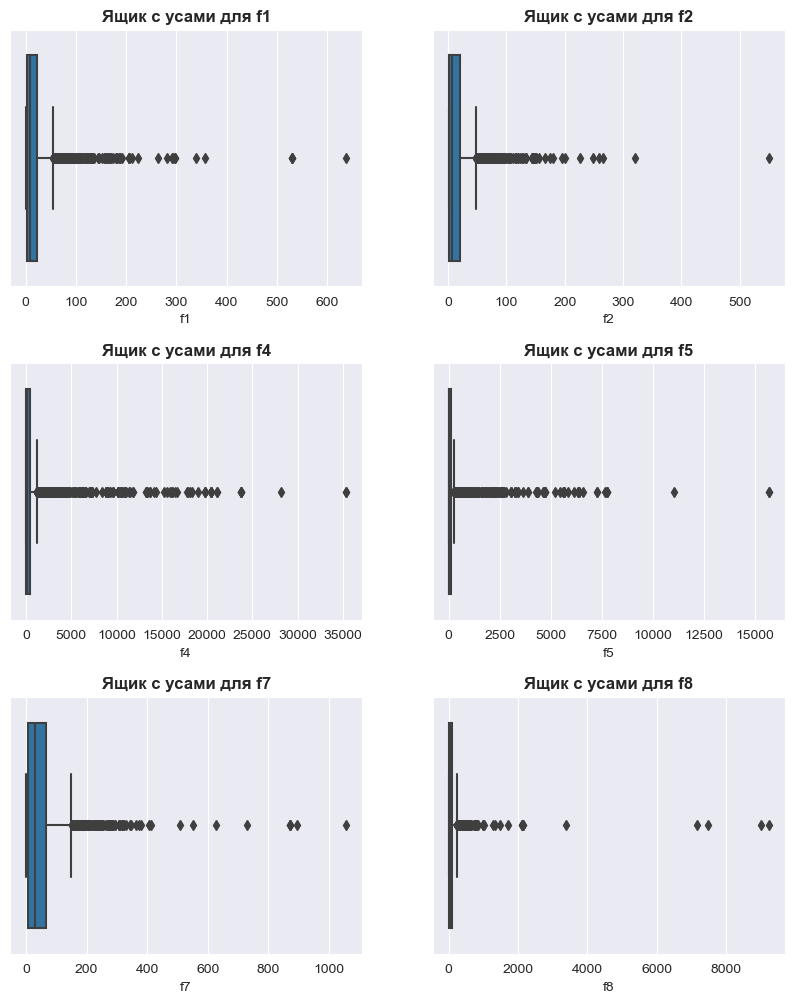

In [32]:
def box_plt(df, col_name, ax):
    sns.boxplot(x=col_name, data=df, ax=ax)
    ax.set_title(f'Ящик с усами для {col_name}', 
                 fontsize=12, weight='bold')
    
f_cols1 = ['f' + str(i) for i in range(1, 9) if i not in (3, 6)]
plt_arr = np.reshape(f_cols1, (3, 2))

fig, axs = plt.subplots(3, 2, figsize=(10, 12))
for i in range(3):
    for j in range(2):
        cur_col = plt_arr[i][j]
        box_plt(df, cur_col, axs[i][j])
        
fig.subplots_adjust(hspace=0.3)
plt.show()

In [40]:
df_copy = df.copy()

In [41]:
for col in f_cols1:
    print(col, ':')
    q1 = df_copy[col].quantile(0.25)
    q3 = df_copy[col].quantile(0.75)
    iqr = q3 - q1
    outliers = (df_copy[col] < (q1 - 1.5 * iqr)) | (df_copy[col] > (q3 + 1.5 * iqr))
    print(f'Нижний порог = {q1 - 1.5 * iqr}, верхний = {q3 + 1.5 * iqr}')
    print(f'Найдено {outliers.sum()} выбросов')
    print(f'Среди них {df_copy[outliers].label.sum()} фейковых')
    if input('Удалить выбросы? (y/n) ') == 'y':
        if input('Изменить пороги? (y/n) ') == 'y':
            thres_up = int(input('Верхний порог: '))
            outliers = (df_copy[col] < thres_low) | (df_copy[col] > thres_up)
            print(f'Найдено {outliers.sum()} выбросов')
            print(f'Среди них {df_copy[outliers].label.sum()} фейковых')
            if input('Удалить выбросы? (y/n) ') == 'y':
                df_copy = df_copy[~outliers]        
        else:
            df_copy = df_copy[~outliers]

f1 :
Нижний порог = -29.5, верхний = 54.5
Найдено 249 выбросов
Среди них 56 фейковых
Удалить выбросы? (y/n) y
Изменить пороги? (y/n) n
f2 :
Нижний порог = -19.0, верхний = 37.0
Найдено 128 выбросов
Среди них 17 фейковых
Удалить выбросы? (y/n) y
Изменить пороги? (y/n) n
f4 :
Нижний порог = -692.5, верхний = 1223.5
Найдено 373 выбросов
Среди них 126 фейковых
Удалить выбросы? (y/n) y
Изменить пороги? (y/n) n
f5 :
Нижний порог = -76.0, верхний = 140.0
Найдено 259 выбросов
Среди них 81 фейковых
Удалить выбросы? (y/n) y
Изменить пороги? (y/n) n
f7 :
Нижний порог = -60.0, верхний = 116.0
Найдено 100 выбросов
Среди них 22 фейковых
Удалить выбросы? (y/n) y
Изменить пороги? (y/n) n
f8 :
Нижний порог = -87.0, верхний = 169.0
Найдено 78 выбросов
Среди них 33 фейковых
Удалить выбросы? (y/n) y
Изменить пороги? (y/n) n


In [42]:
df_copy.shape[0]

1935

In [43]:
df_copy.label.mean()

0.2532299741602067

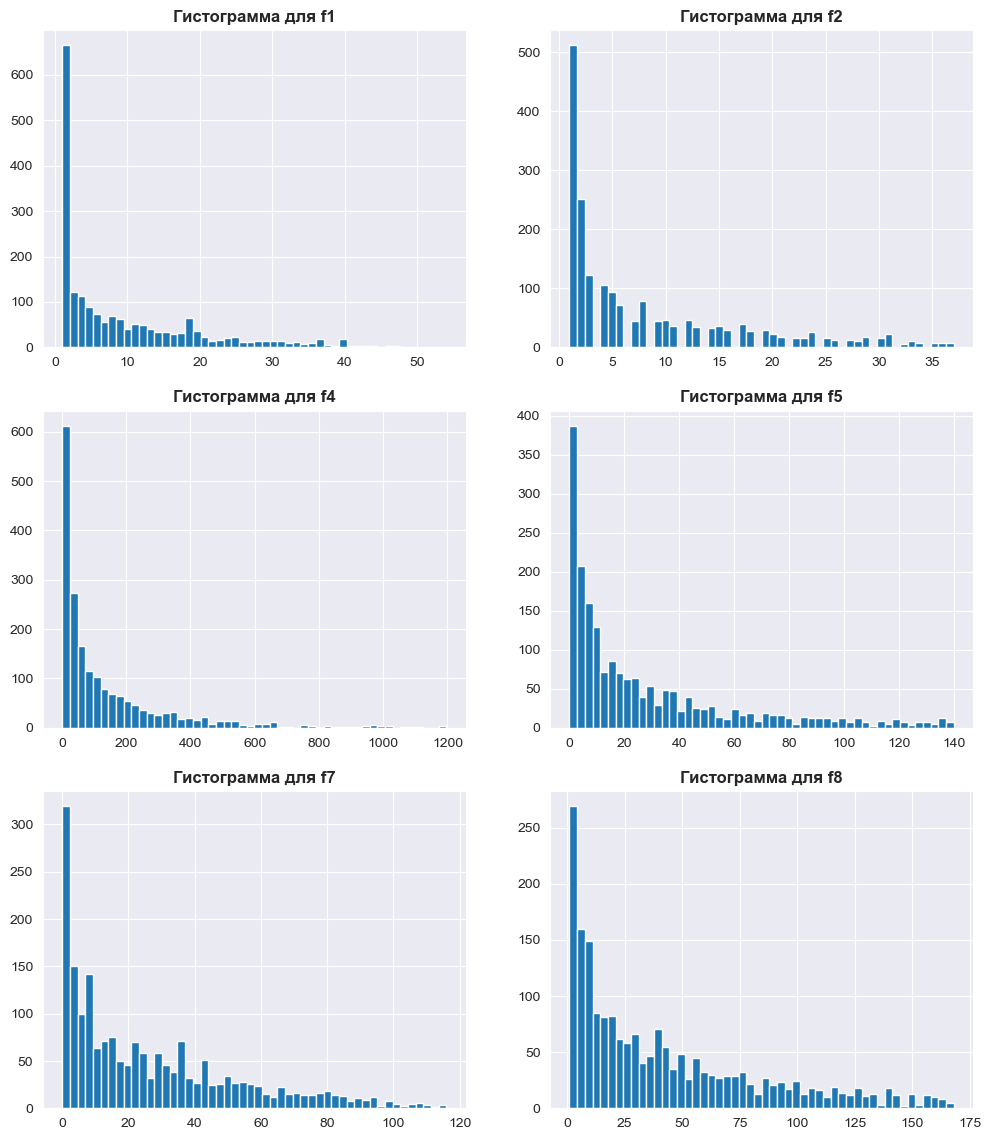

In [44]:
plt_arr = np.reshape(f_cols1, (3, 2))

fig, axs = plt.subplots(3, 2, figsize=(12, 14))
for i in range(3):
    for j in range(2):
        cur_col = plt_arr[i][j]
        df_copy[cur_col].hist(ax=axs[i][j], bins=50)
        axs[i][j].set_title(f'Гистограмма для {cur_col}', weight='bold')
plt.show()

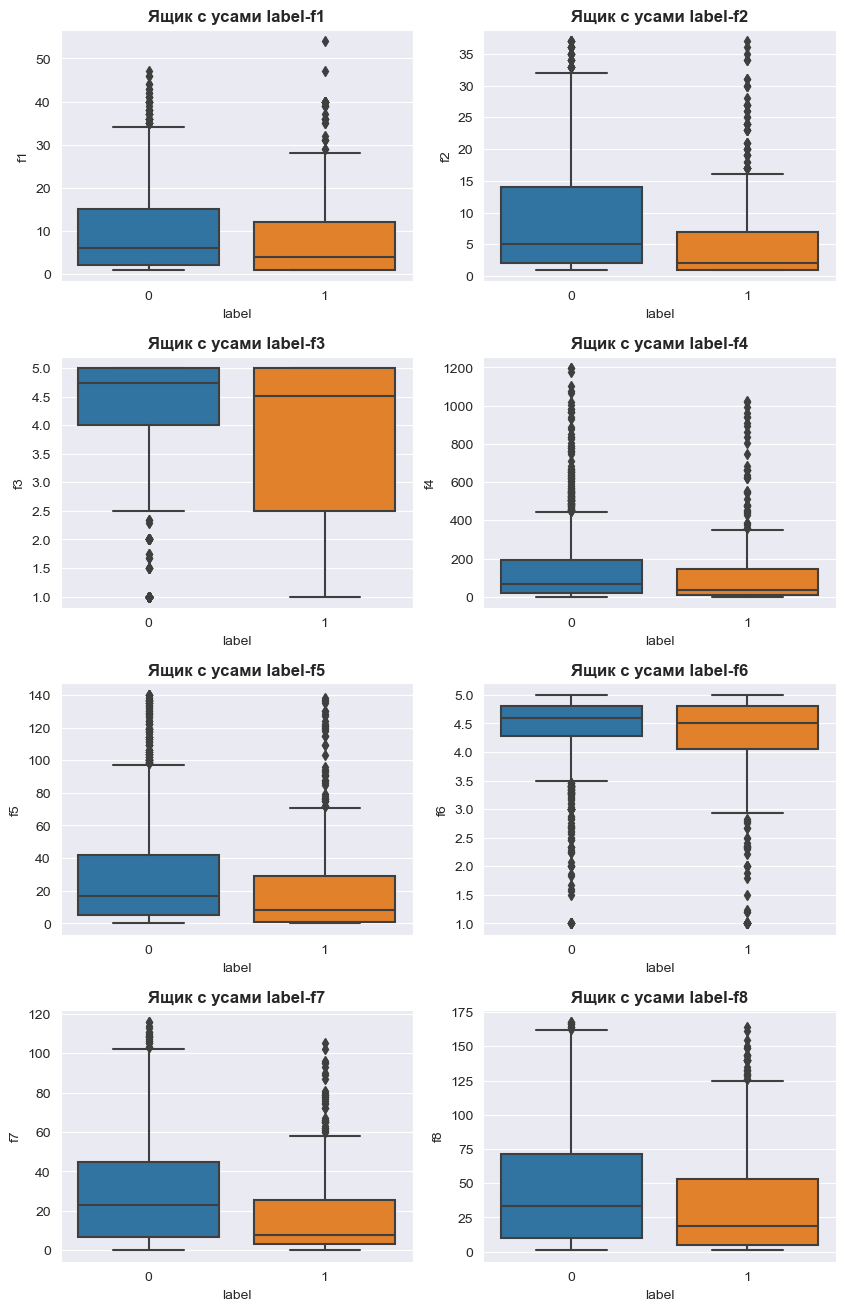

In [45]:
def box_plt(df, col_name, ax):
    sns.boxplot(x='label', y=col_name, data=df, ax=ax)
    ax.set_title(f'Ящик с усами label-{col_name}', 
                 fontsize=12, weight='bold')
    
fig, axs = plt.subplots(4, 2, figsize=(10, 16))
plt_arr = np.reshape(f_cols, (4, 2))
for i in range(4):
    for j in range(2):
        cur_col = plt_arr[i][j]
        box_plt(df_copy, cur_col, axs[i][j])
        
fig.subplots_adjust(hspace=0.3)
plt.show()

## Предобработка текстов

In [30]:
m = MorphAnalyzer()
stop = stopwords.words('russian') + list(punctuation)

In [31]:
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form


def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]        


def preprocess_text(text, stop_w=stop, tokenizer=word_tokenize):  
    """функция предобработки текста"""
    # удаляем все, кроме букв кириллицы
    text = re.sub('[^А-Яа-яёЁ\s]', ' ', text)
    # приводим к нижнему регистру и разбиваем на слова по символу пробела
    text = tokenizer(text.lower(), language='russian')
    text = [w for w in text if (w.replace('ё', 'е') not in stop_w) and (len(w) > 2)]
    text = lemmatize_text(text)  # лемматизируем
    return ' '.join(text)

In [32]:
tqdm.pandas()
df['clear_text'] = df.text.progress_apply(preprocess_text)

100%|█████████████████████████████████████████████████████████████████████████████| 3122/3122 [00:04<00:00, 667.29it/s]


In [33]:
df[['text', 'clear_text']].head(10)

text  \
0  Хотела купить на замену старых,по итогу эти  у...   
1  Запах по сравнению с обычным DOVE никакой. Оно...   
2                   Кабель подошёл, хорошо работает.   
3  Восторг! Очень приятный аромат, держится долго...   
4  Визуально все хорошо. Не пробовали. Купили в п...   
5  Коробка в состоянии,, прошла Афган,,! Гладкая ...   
6  Джинсы хорошие качество отличное но дороговаты...   
7                                   Хорошее качество   
8      Камеры не закрывает, камеры в ровень с чехлом   
9  Юлия не могли бы Вы проверить стеганку которую...   

                                          clear_text  
0  хотеть купить замена старый итог ужаснотупой у...  
1  запах сравнение обычный никакой оно парфюмиров...  
2                            кабель подойти работать  
3  восторг очень приятный аромат держаться долго ...  
4                 визуально пробовать купить подарок  
5  коробка состояние пройти афган гладкий кожа но...  
6  джинсы хороший качество отличный дороговатый м...  
7                                   хороший качество  
8               камера закрывать камера ровеня чехол  
9  юлия мочь проверить стёганка который вернуть к...

Есть небольшая проблема, состоящая в том, что для нескольких отзывов мы из-за такой очистки, по сути, совсем лишились текста отзыва. Также есть проблема, связанная с опечатками

In [34]:
df[(df.clear_text.str.split().str.len() == 0)]

id1                   id2                   id3  \
23    14932418852539196783  11594206611029735520   5576082564072164535   
369    8816573192000644470   5561072876759097566   7279234113731486608   
408    7228372016730991648   5850695483357674592   8160404367092487937   
637   14533498944280804100  11860455876991826814  15053676552810216566   
751   10749861286048421051  14949176600961148554   8223254633971568382   
897   16003434369235304523  14926672264371803806   8223254633971568382   
914    9158133609663457546  11023721191884698213  13057272459692676590   
1218  18020901957991569865  11775626371433002033  17776117386538683712   
1298  15376744332096648284   6268099669634872571   6836784353719029392   
1374   7542702795411835022   9749876112909188500   7249931646404503757   
2033  10534561889744850887   9182191085668740569  12049502514293004650   
2299   1245898986917320135   6855420157049629570  11327471499625535952   
2692   8719697056248631083  10342866770060929957   1334598763207459993   

                  text  f1  f2        f3    f4   f5        f6  ...  text_len  \
23         ︎ ︎ ︎ ︎ ︎ ︎   8   7  5.000000    96   27  4.520833  ...        11   
369        Ок ок ок ок   7   7  4.428571    23    2  4.739130  ...        11   
408         __________   2   2  2.500000    27    3  4.111111  ...        10   
637             👍👍👍👍👍👍  13  13  4.846154   881  175  4.611805  ...         6   
751         Все хорошо  29  27  4.862069    27    5  4.518519  ...        10   
897        Всё хорошо.  18  18  4.777778    11    0  4.727273  ...        11   
914   Хорошо но не тот   1   1  5.000000   198   68  4.156566  ...        16   
1218         👌👍🏼👍🏼👍🏼👍🏼   6   6  5.000000    17    1  4.235294  ...         9   
1298    Всё хорошо ...   4   4  5.000000    48    4  4.395833  ...        14   
1374        Всё хорошо  16  16  4.750000   328   58  4.649390  ...        10   
2033        Всё хорошо  45  31  4.733333  1067  354  4.949391  ...        10   
2299        👍👍👍👍👍👍👍👍👍👍   1   1  5.000000     3    0  3.666667  ...        10   
2692        Все хорошо  34  32  5.000000   242   95  4.685950  ...        10   

      word_count  sent_count  avg_word_len  avg_sent_len  caps_portion  \
23             6           1      1.000000          11.0      0.000000   
369            4           1      2.000000          11.0      0.090909   
408            1           1     10.000000          10.0      0.000000   
637            1           1      6.000000           6.0      0.000000   
751            2           1      4.500000          10.0      0.100000   
897            3           1      3.333333          11.0      0.090909   
914            4           1      3.250000          16.0      0.062500   
1218           1           1      9.000000           9.0      0.000000   
1298           3           1      4.000000          14.0      0.071429   
1374           2           1      4.500000          10.0      0.100000   
2033           2           1      4.500000          10.0      0.100000   
2299           1           1     10.000000          10.0      0.000000   
2692           2           1      4.500000          10.0      0.100000   

      punct_portion        f9       f10  clear_text  
23         0.000000  0.281250  0.875000              
369        0.000000  0.086957  1.000000              
408        1.000000  0.111111  1.000000              
637        0.000000  0.198638  1.000000              
751        0.000000  0.185185  0.931034              
897        0.090909  0.000000  1.000000              
914        0.000000  0.343434  1.000000              
1218       0.000000  0.058824  1.000000              
1298       0.214286  0.083333  1.000000              
1374       0.000000  0.176829  1.000000              
2033       0.000000  0.331771  0.688889              
2299       0.000000  0.000000  1.000000              
2692       0.000000  0.392562  0.941176              

[13 rows x 23 columns]

## Перейдем к обучению моделей

In [35]:
def custom_f_beta(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=0.5)


fbeta_gs = make_scorer(custom_f_beta, greater_is_better=True)

In [36]:
def cv_log_results(model, X, y, scoring=fbeta_gs, cv=10):
    """
    Функция для вывода результатов кросс-валидации
    (среднего и стандартного отклонения метрики по фолдам).
    """
    cv_scores = cross_val_score(model, X, y, scoring=scoring, cv=cv)
    return cv_scores.mean(), cv_scores.std()

In [37]:
def print_metrics(model, X_train, y_train, X_test, 
                  y_test, config_name, train_time, inference_time, cv=True):
    train_dct, test_dct = {}, {}  # словари для хранения метрик
    dct_lst = [train_dct, test_dct]
    
    start_train = time.perf_counter()
    pred_train, probs_train = model.predict(X_train), model.predict_proba(X_train)[:, 1]
    train_time += time.perf_counter() - start_train
    
    start_inf = time.perf_counter()  # замеряем время инференса 
    pred_test, probs_test = model.predict(X_test), model.predict_proba(X_test)[:, 1]
    inference_time += time.perf_counter() - start_inf
    metrics = {'precision': precision_score, 'recall': recall_score,
               'F1': f1_score, r'F$\beta$': fbeta_score}
    for m in metrics:  # проходим по всем функциям расчета метрик
        for i, cur_set in enumerate(zip([y_train, y_test], 
                                     [pred_train, pred_test])):
            if m == r'F$\beta$':
                dct_lst[i][m] = metrics[m](*cur_set, beta=0.5)
            else:
                dct_lst[i][m] = metrics[m](*cur_set)  # сохраняем значения метрик
            
    res_df = pd.DataFrame({'train': train_dct, 'test': test_dct}).T
    res_df['roc_auc'] = [
        roc_auc_score(y_train, probs_train),
        roc_auc_score(y_test, probs_test),
    ]
    p1, r1, t1 = pr_curve(y_train, probs_train)
    p2, r2, t2 = pr_curve(y_test, probs_test)
    res_df['pr_auc'] = [auc(r1, p1), auc(r2, p2)]
    if cv == True:  # кросс-валидация
        cv_mean, cv_std = cv_log_results(model, X_train, y_train)
        res_df.loc['train', 'cv'] = str(round(cv_mean, 2)) + '$\pm$' + str(round(cv_std, 2))
        res_df.loc['test', 'cv'] = str(round(cv_mean, 2)) + '$\pm$' + str(round(cv_std, 2))
    res_df.loc['train', 'train_time'] = str(round(train_time * 10 ** 3, 2)) + ' ms'
    res_df.loc['test', 'inference_time'] = str(round(inference_time * 10 ** 3, 2)) + ' ms'
    res_df = res_df.round(3)
    res_df.index = pd.MultiIndex.from_tuples(zip([config_name] * 2, res_df.index), 
                                             names=['configuration', 'set'])
    display(res_df)
    return res_df

In [38]:
def fit_and_metrics(model, X_train, y_train, X_test, y_test,
                    config_name, column_transformer, cv=True):
    start = time.perf_counter()  # сохраняем время на скейлинг
    X_train_transf = column_transformer.fit_transform(X_train)
    train_time = time.perf_counter() - start
    start = time.perf_counter()  
    X_test_transf = column_transformer.transform(X_test)
    inference_time = time.perf_counter() - start
    start = time.perf_counter()
    model.fit(X_train_transf, y_train)  # обучаем модель и логируем метрики
    train_time += time.perf_counter() - start
    res_df = print_metrics(model, X_train_transf, y_train,
                           X_test_transf, y_test, config_name,
                           train_time, inference_time, cv)
    return model, res_df

## L4. Бейзлайн

In [39]:
X, y = df.loc[:, 'f1': 'f8'], df.label

In [40]:
X.head(3)

f1  f2   f3  f4  f5        f6  f7   f8
0   1   1  1.0  11  13  4.272727  18   36
1  10   6  2.7  46   4  4.434783  90  109
2   4   4  4.0  14   0  4.500000   4    6

## L3. Разбиение на train/test

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

In [42]:
column_transformer = ColumnTransformer([('scaler', StandardScaler(),
                                         X_train.columns)])

**Посмотрим сперва константный классификатор**

In [43]:
dummy_base = DummyClassifier(strategy='constant', constant=1)
dummy_base, res_df_dummy_base = fit_and_metrics(dummy_base, X_train, y_train,
                                                X_test, y_test,
                                                'dummy_baseline',
                                                column_transformer)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration  set                                                          
dummy_baseline train      0.264     1.0  0.418      0.31      0.5   0.632   
               test       0.264     1.0  0.418      0.31      0.5   0.632   

                                cv train_time inference_time  
configuration  set                                            
dummy_baseline train  0.31$\pm$0.0    5.75 ms            NaN  
               test   0.31$\pm$0.0        NaN        3.04 ms

**В качестве бейзлайна возьмем модель на признаках f1-f8**

In [44]:
simple_base = SVC(probability=True, random_state=42, class_weight='balanced')
simple_base, res_df_simple_base = fit_and_metrics(simple_base, X_train,
                                                  y_train, X_test, y_test,
                                                  'simple_baseline',
                                                  column_transformer)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration   set                                                          
simple_baseline train      0.448   0.633  0.525     0.476    0.727   0.551   
                test       0.422   0.558  0.480     0.444    0.732   0.496   

                                  cv  train_time inference_time  
configuration   set                                              
simple_baseline train  0.45$\pm$0.03  2726.72 ms            NaN  
                test   0.45$\pm$0.03         NaN      241.91 ms

### Обучим модель без текстовых фичей

**Разбиение и нормировка для случая без использования фичей punct_portion, f9, f10**

In [45]:
X, y = df.drop(columns=['punct_portion', 'f9', 'f10', 'label']), df.label

In [46]:
X = X.drop(columns=['id1', 'id2', 'id3', 'text', 'clear_text'])

In [47]:
X.head(3)

f1  f2   f3  f4  f5        f6  f7   f8  text_len  word_count  sent_count  \
0   1   1  1.0  11  13  4.272727  18   36        96          21           1   
1  10   6  2.7  46   4  4.434783  90  109        99          17           3   
2   4   4  4.0  14   0  4.500000   4    6        32           6           1   

   avg_word_len  avg_sent_len  caps_portion  
0      3.857143     96.000000      0.010417  
1      5.000000     32.333333      0.070707  
2      4.833333     32.000000      0.031250

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)
print(len(y_train), 'объектов в обучающей выборке')
print(len(y_test), 'объектов в тестовой выборке')

2497 объектов в обучающей выборке
625 объектов в тестовой выборке


In [49]:
numeric = list(X.loc[:, :'caps_portion'].columns)
print(numeric)

column_transformer = ColumnTransformer([('scaler', StandardScaler(), numeric)],
                                       remainder='passthrough')

['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'text_len', 'word_count', 'sent_count', 'avg_word_len', 'avg_sent_len', 'caps_portion']


**Разбиение и нормировка для случая с использованием фичей punct_portion, f9, f10**

In [50]:
X1, y = df.drop(columns=['label']), df.label

In [51]:
X1 = X1.drop(columns=['id1', 'id2', 'id3', 'text', 'clear_text'])

In [52]:
X1.head(3)

f1  f2   f3  f4  f5        f6  f7   f8  text_len  word_count  sent_count  \
0   1   1  1.0  11  13  4.272727  18   36        96          21           1   
1  10   6  2.7  46   4  4.434783  90  109        99          17           3   
2   4   4  4.0  14   0  4.500000   4    6        32           6           1   

   avg_word_len  avg_sent_len  caps_portion  punct_portion        f9  f10  
0      3.857143     96.000000      0.010417       0.052083  1.181818  1.0  
1      5.000000     32.333333      0.070707       0.020202  0.086957  0.6  
2      4.833333     32.000000      0.031250       0.062500  0.000000  1.0

In [53]:
X_train1, X_test1, y_train, y_test = train_test_split(X1, y, test_size=0.2, 
                                                      random_state=42, stratify=y)

In [54]:
numeric1 = list(X1.loc[:, :'f10'].columns)
print(numeric1)

column_transformer1 = ColumnTransformer([('scaler', StandardScaler(), numeric1)],
                                        remainder='passthrough')

['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'text_len', 'word_count', 'sent_count', 'avg_word_len', 'avg_sent_len', 'caps_portion', 'punct_portion', 'f9', 'f10']


**Обучение моделей**

NB. Здесь и далее "1" в конце названия модели означает, что модель обучалась на всех фичах.

In [55]:
lr_no_text = LogisticRegression(max_iter=5000, random_state=42,
                                class_weight='balanced')
lr_no_text, res_df_lr_no_text = fit_and_metrics(lr_no_text, X_train, y_train,
                                                X_test, y_test, 'lr_no_text',
                                                column_transformer)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
lr_no_text    train      0.438   0.555  0.490     0.457    0.708   0.500   
              test       0.456   0.570  0.507     0.475    0.742   0.512   

                                cv train_time inference_time  
configuration set                                             
lr_no_text    train  0.45$\pm$0.03   45.03 ms            NaN  
              test   0.45$\pm$0.03        NaN        3.19 ms

In [56]:
# с добавлением доп. фичей
lr_no_text1 = LogisticRegression(max_iter=5000, random_state=42,
                                 class_weight='balanced')
lr_no_text1, res_df_lr_no_text1 = fit_and_metrics(lr_no_text1, X_train1, y_train,
                                                  X_test1, y_test, 'lr_no_text1',
                                                  column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
lr_no_text1   train      0.462   0.545  0.500     0.477    0.723   0.549   
              test       0.484   0.564  0.521     0.498    0.739   0.549   

                                cv train_time inference_time  
configuration set                                             
lr_no_text1   train  0.46$\pm$0.05    26.2 ms            NaN  
              test   0.46$\pm$0.05        NaN        2.89 ms

In [57]:
def grid_search_cv(model, X, y, params, column_transformer,
                   scoring=fbeta_gs, cv=5, transf=True):  #scoring='f1'
    """
    Grid search для тюнинга гиперпараметров по кросс-валидации.
    """
    gscv = GridSearchCV(model, params, scoring=scoring, cv=cv, n_jobs=-1)
    if transf:
        gscv.fit(column_transformer.fit_transform(X), y)
    else:
        gscv.fit(X, y)
    print('Best score: %.5f' % gscv.best_score_)
    print('Best params:', gscv.best_params_)
    return gscv

In [58]:
def grid_search_val(model, X_train, y_train, X_test, y_test,
                    params, column_transformer, scoring=fbeta_gs, transf=False):
    X_train_transf = column_transformer.fit_transform(X_train)
    X_test_transf = column_transformer.transform(X_test)
    cv_X_data = np.vstack([X_train_transf, X_test_transf])
    cv_y_data = np.hstack([y_train, y_test])
    split_index = np.hstack([-1 * np.ones(X_train_transf.shape[0]), 
                             np.zeros(X_test_transf.shape[0])])
    pds = PredefinedSplit(test_fold=split_index)
    gs = grid_search_cv(model, cv_X_data, cv_y_data, 
                        params, column_transformer, cv=pds, transf=transf)
    return gs

In [59]:
params = {
    'C': np.logspace(-3, 1, 20),
    'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')
}
model = LogisticRegression(max_iter=5000, random_state=42,
                           class_weight='balanced')

lr_gs = grid_search_cv(model, X_train, y_train, 
                       params, column_transformer, cv=10)

Best score: 0.45569
Best params: {'C': 6.158482110660261, 'solver': 'saga'}


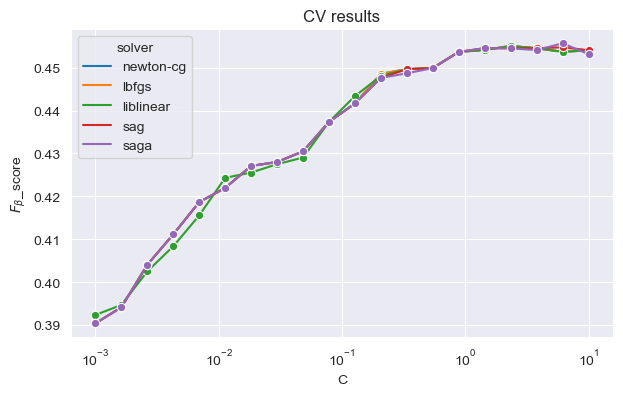

In [62]:
cv_res_df = pd.DataFrame(lr_gs.cv_results_['params'])
cv_res_df[r'$F_\beta$_score'] = lr_gs.cv_results_['mean_test_score']

fig = plt.figure(figsize=(7, 4))
sns.lineplot(data=cv_res_df, x='C', y=r'$F_\beta$_score', hue='solver', marker='o')
plt.title('CV results')
plt.xscale('log')
plt.show()

In [60]:
lr_no_text_cv = LogisticRegression(max_iter=5000, random_state=42,
                                   class_weight='balanced', **lr_gs.best_params_)
lr_no_text_cv, res_df_lr_no_text_cv = fit_and_metrics(lr_no_text_cv, X_train, y_train, 
                                                      X_test, y_test, 'lr_no_text_cv',
                                                      column_transformer)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
lr_no_text_cv train      0.439   0.556  0.491     0.458    0.709   0.506   
              test       0.468   0.576  0.516     0.486    0.745   0.518   

                                cv train_time inference_time  
configuration set                                             
lr_no_text_cv train  0.46$\pm$0.03  361.75 ms            NaN  
              test   0.46$\pm$0.03        NaN        2.91 ms

In [61]:
def cv_results(model, X, y, column_transformer, cv=10, scoring=fbeta_gs):
    X_transf = column_transformer.fit_transform(X)
    cv_scores = cross_val_score(model, X_transf, y, scoring=scoring, cv=cv)  # по умолчанию StratifiedKFold
    print('CV-scores:', ' | '.join(map(lambda x: str(round(x, 2)), cv_scores)))
    print(f'CV results on {cv} folds: mean=%.4f, std=%.3f' % (cv_scores.mean(), cv_scores.std()))

In [65]:
cv_results(LogisticRegression(max_iter=5000, random_state=42, 
                              class_weight='balanced', **lr_gs.best_params_), 
           X_train, y_train, column_transformer)

CV-scores: 0.49 | 0.49 | 0.44 | 0.45 | 0.43 | 0.46 | 0.51 | 0.45 | 0.4 | 0.43
CV results on 10 folds: mean=0.4557, std=0.031


In [155]:
feat_names = column_transformer1.transformers_[0][2]
cols_coefs = list(zip(feat_names, lr_no_text1.coef_[0]))
cols_coefs_sorted = sorted(cols_coefs, key=lambda x: abs(x[1]), reverse=True) 

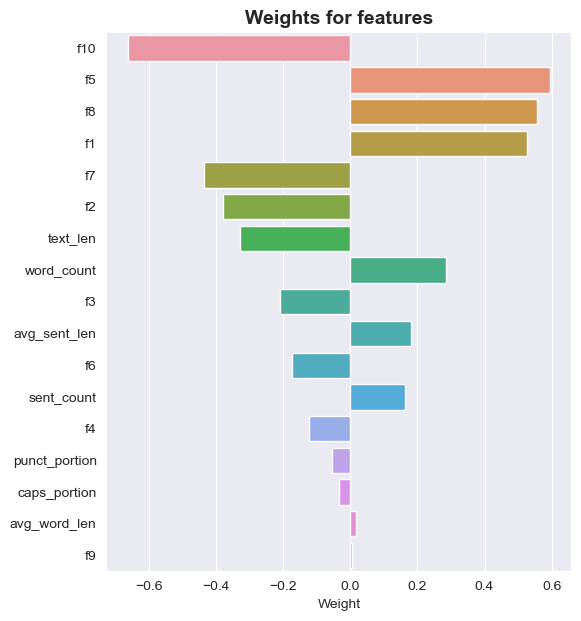

In [156]:
def show_weights(features_weights, linear=True, num=30):
    plt.figure(figsize=(6, 7))
    weights = [x[1] for x in features_weights[:num]]
    features = [x[0] for x in features_weights[:num]]
    sns.barplot(y=features, x=weights)
    plt.xlabel('Weight')
    plt.title('Weights for features', weight='bold', fontsize=14)
    plt.show()
    return features

feat = show_weights(cols_coefs_sorted)

**Подведем итог по моделям без текстов**

In [62]:
no_text_final = pd.concat([res_df_dummy_base, res_df_simple_base,
                           res_df_lr_no_text, res_df_lr_no_text_cv,
                           res_df_lr_no_text1])
no_text_final

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration   set                                                          
dummy_baseline  train      0.264   1.000  0.418     0.310    0.500   0.632   
                test       0.264   1.000  0.418     0.310    0.500   0.632   
simple_baseline train      0.448   0.633  0.525     0.476    0.727   0.551   
                test       0.422   0.558  0.480     0.444    0.732   0.496   
lr_no_text      train      0.438   0.555  0.490     0.457    0.708   0.500   
                test       0.456   0.570  0.507     0.475    0.742   0.512   
lr_no_text_cv   train      0.439   0.556  0.491     0.458    0.709   0.506   
                test       0.468   0.576  0.516     0.486    0.745   0.518   
lr_no_text1     train      0.462   0.545  0.500     0.477    0.723   0.549   
                test       0.484   0.564  0.521     0.498    0.739   0.549   

                                  cv  train_time inference_time  
configuration   set                                              
dummy_baseline  train   0.31$\pm$0.0     5.75 ms            NaN  
                test    0.31$\pm$0.0         NaN        3.04 ms  
simple_baseline train  0.45$\pm$0.03  2726.72 ms            NaN  
                test   0.45$\pm$0.03         NaN      241.91 ms  
lr_no_text      train  0.45$\pm$0.03    45.03 ms            NaN  
                test   0.45$\pm$0.03         NaN        3.19 ms  
lr_no_text_cv   train  0.46$\pm$0.03   361.75 ms            NaN  
                test   0.46$\pm$0.03         NaN        2.91 ms  
lr_no_text1     train  0.46$\pm$0.05     26.2 ms            NaN  
                test   0.46$\pm$0.05         NaN        2.89 ms

### Bag-of-words

In [63]:
vectorizer = CountVectorizer(preprocessor=preprocess_text, tokenizer=word_tokenize,
                             min_df=4, token_pattern='[А-Яа-яёЁ\s]+')
bow = vectorizer.fit_transform(df.clear_text)
bow

<3122x1075 sparse matrix of type '<class 'numpy.int64'>'
	with 19455 stored elements in Compressed Sparse Row format>

In [64]:
bow_df = pd.DataFrame(bow.toarray(),
                      columns=vectorizer.get_feature_names_out(),
                      index=df.index)

**Разбиение и нормировка для случая без использования фичей punct_portion, f9, f10**

In [65]:
X_bow = pd.concat([X, bow_df], axis=1)

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

**Разбиение и нормировка для случая с использованием фичей punct_portion, f9, f10**

In [67]:
X_bow1 = pd.concat([X1, bow_df], axis=1)

In [68]:
X_train1, X_test1, y_train, y_test = train_test_split(X_bow1, y, test_size=0.2, 
                                                      random_state=42, stratify=y)

#### Обучение моделей

Здесь и далее буду в основном придерживаться такого подхода: сперва обучение модели с дефолтными параметрами, затем тюнинг гиперпараметров для улучшения качества

**KNN**

Обучим модель с дефолтными параметрами

In [69]:
knn_bow1 = KNeighborsClassifier()
knn_bow1, res_df_knn_bow1 = fit_and_metrics(knn_bow1, X_train1, y_train,
                                            X_test1, y_test, 'knn_bow1',
                                            column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
knn_bow1      train      0.794   0.415  0.545     0.672    0.857   0.725   
              test       0.600   0.273  0.375     0.484    0.644   0.488   

                                cv train_time inference_time  
configuration set                                             
knn_bow1      train  0.48$\pm$0.06  937.17 ms            NaN  
              test   0.48$\pm$0.06        NaN      354.57 ms

Модель явно переобучена, используем GridSearch, чтобы потюнить гиперпараметры и улучшить качество

In [70]:
params = {
    'n_neighbors': range(1, 23, 2),
    'weights': ('uniform', 'distance'),
    'p': (1, 2)
}
model = KNeighborsClassifier()

knn_gs_bow = grid_search_val(model, X_train1, y_train, X_test1, y_test,
                             params, column_transformer1)

Best score: 0.50992
Best params: {'n_neighbors': 17, 'p': 2, 'weights': 'uniform'}


In [71]:
knn_bow_cv1 = KNeighborsClassifier(**knn_gs_bow.best_params_) 
knn_bow_cv1, res_df_knn_bow_cv1 = fit_and_metrics(
    knn_bow_cv1, X_train1, y_train, X_test1, y_test,
    'knn_bow_cv1', column_transformer1
)

precision  recall    F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                         
knn_bow_cv1   train      0.826   0.230  0.36     0.544    0.774   0.611   
              test       0.766   0.218  0.34     0.510    0.703   0.518   

                                cv train_time inference_time  
configuration set                                             
knn_bow_cv1   train  0.48$\pm$0.09  945.05 ms            NaN  
              test   0.48$\pm$0.09        NaN      399.36 ms

Стало лучше

**Сохраним выбранную модель и сэмпл для инференса**

In [165]:
with open('column_transformer.pkl', 'wb') as f1:
    pickle.dump(column_transformer1, f1)

with open('bow_vectorizer.pkl', 'wb') as f2:
    pickle.dump(vectorizer, f2)

with open('knn_bow_cv1.pkl', 'wb') as f3:
    pickle.dump(knn_bow_cv1, f3)

In [166]:
with open('bow_vectorizer.pkl', 'rb') as f2:
    vectorizer = pickle.load(f2)

In [ ]:
# data_sample = pd.read_csv('wb_school_task_2.csv.gzip', compression='gzip').drop(columns='label').sample(100, random_state=15)
# data_sample.to_csv('sample_data.csv', index=False)
# pd.read_csv('wb_school_task_2.csv.gzip', compression='gzip').sample(100, random_state=15).label.values.nonzero()

**LogReg**

In [72]:
lr_bow1 = LogisticRegression(max_iter=5000, random_state=42, 
                             class_weight='balanced')
lr_bow1, res_df_lr_bow1 = fit_and_metrics(
    lr_bow1, X_train1, y_train, X_test1, y_test,
    'lr_bow1', column_transformer1
)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
lr_bow1       train      0.722   0.800  0.759     0.737    0.924   0.842   
              test       0.476   0.491  0.484     0.479    0.661   0.487   

                                cv train_time inference_time  
configuration set                                             
lr_bow1       train  0.47$\pm$0.04  579.93 ms            NaN  
              test   0.47$\pm$0.04        NaN       13.01 ms

Явный оверфит

In [77]:
params = {'C': np.logspace(-3, 1, 15), 
          'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
model = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')

lr_gs_bow = grid_search_val(model, X_train1, y_train, X_test1, y_test,
                            params, column_transformer1)

Best score: 0.51925
Best params: {'C': 0.013894954943731374, 'solver': 'liblinear'}


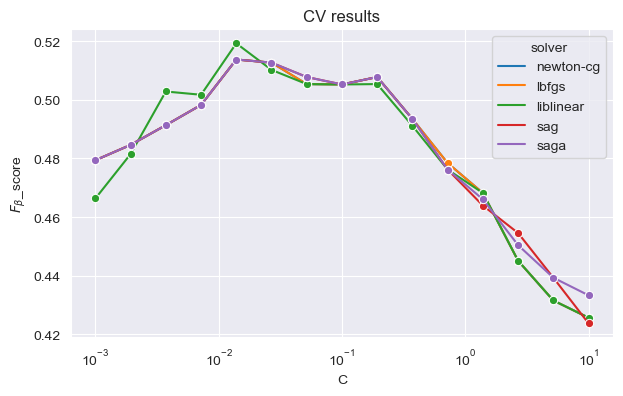

In [154]:
cv_res_df_bow = pd.DataFrame(lr_gs_bow.cv_results_['params'])
cv_res_df_bow[r'$F_\beta$_score'] = lr_gs_bow.cv_results_['mean_test_score']

fig = plt.figure(figsize=(7, 4))
sns.lineplot(data=cv_res_df_bow, x='C', y=r'$F_\beta$_score', hue='solver', marker='o')
plt.title('CV results')
plt.xscale('log')
plt.show()

In [73]:
lr_bow_cv1 = LogisticRegression(max_iter=5000, random_state=42,
                                class_weight='balanced', **lr_gs_bow.best_params_)
lr_bow_cv1, res_df_lr_bow_cv1 = fit_and_metrics(lr_bow_cv1, X_train1, y_train,
                                                X_test1, y_test, 'lr_bow_cv1',
                                                column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
lr_bow_cv1    train      0.509   0.570  0.538     0.520    0.768   0.597   
              test       0.514   0.539  0.527     0.519    0.740   0.541   

                                cv train_time inference_time  
configuration set                                             
lr_bow_cv1    train  0.48$\pm$0.05   72.56 ms            NaN  
              test   0.48$\pm$0.05        NaN        10.8 ms

**SVM**

In [74]:
svm_bow1 = SVC(C=0.15, class_weight='balanced',
               probability=True, random_state=42)
svm_bow1, res_df_svm_bow1 = fit_and_metrics(svm_bow1, X_train1, y_train,
                                            X_test1, y_test, 'svm_bow1',
                                            column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
svm_bow1      train      0.471   0.629  0.539     0.496    0.773   0.631   
              test       0.447   0.558  0.496     0.465    0.750   0.553   

                                cv   train_time inference_time  
configuration set                                               
svm_bow1      train  0.46$\pm$0.03  32049.36 ms            NaN  
              test   0.46$\pm$0.03          NaN     2369.26 ms

In [80]:
params = {'C': np.linspace(0.01, 0.2, 7), 
          'kernel': ('linear', 'rbf')}
model = SVC(class_weight='balanced', probability=True, random_state=42)

svm_gs_bow = grid_search_val(model, X_train1, y_train, X_test1, y_test,
                             params, column_transformer1)

Best score: 0.51604
Best params: {'C': 0.01, 'kernel': 'linear'}


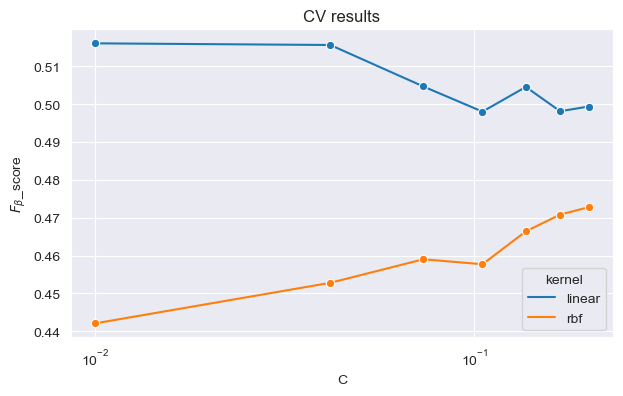

In [111]:
cv_res_df_bow = pd.DataFrame(svm_gs_bow.cv_results_['params'])
cv_res_df_bow[r'$F_\beta$_score'] = svm_gs_bow.cv_results_['mean_test_score']

fig = plt.figure(figsize=(7, 4))
sns.lineplot(data=cv_res_df_bow, x='C', y=r'$F_\beta$_score', hue='kernel', marker='o')
plt.title('CV results')
plt.xscale('log')
plt.show()

In [77]:
svm_bow_cv1 = SVC(class_weight='balanced', probability=True,
                  random_state=42, **svm_gs_bow.best_params_)
svm_bow_cv1, res_df_svm_bow_cv1 = fit_and_metrics(svm_bow_cv1, X_train1, y_train, 
                                                  X_test1, y_test, 'svm_bow_cv1',
                                                  column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
svm_bow_cv1   train      0.551   0.517  0.533     0.544    0.769   0.583   
              test       0.536   0.448  0.488     0.516    0.748   0.549   

                               cv  train_time inference_time  
configuration set                                             
svm_bow_cv1   train  0.5$\pm$0.06  26733.5 ms            NaN  
              test   0.5$\pm$0.06         NaN     1530.67 ms

**LightGBM**

In [78]:
lgbm_bow1 = LGBMClassifier(random_state=42)
lgbm_bow1, res_df_lgbm_bow1 = fit_and_metrics(lgbm_bow1, X_train1, y_train,
                                              X_test1, y_test, 'lgbm_bow1',
                                              column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
lgbm_bow1     train       1.00   0.941  0.970     0.988    1.000   1.000   
              test        0.62   0.297  0.402     0.509    0.712   0.549   

                                cv train_time inference_time  
configuration set                                             
lgbm_bow1     train  0.53$\pm$0.06  380.02 ms            NaN  
              test   0.53$\pm$0.06        NaN        26.4 ms

In [63]:
params = {
    'max_depth': range(3, 10),
    'n_estimators': [50, 75, 100, 125, 150],
    'learning_rate': [0.001, 0.0025, 0.005, 0.01], 
    'reg_lambda': [0.001,  0.0025, 0.005, 0.01, 0.03]
}

model = LGBMClassifier(random_seed=42)
lgbm_gs_bow = grid_search_val(model, X_train1, y_train, X_test1, y_test,
                              params, column_transformer1)

Best score: 0.49853
Best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 150, 'reg_lambda': 0.005}


In [79]:
lgbm_bow_cv1 = LGBMClassifier(random_seed=42, **lgbm_gs_bow.best_params_)
lgbm_bow_cv1, res_df_lgbm_bow_cv1 = fit_and_metrics(lgbm_bow_cv1, X_train1, y_train,
                                                    X_test1, y_test, 'lgbm_bow_cv1', 
                                                    column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
lgbm_bow_cv1  train      0.917   0.283  0.433     0.633    0.843   0.736   
              test       0.773   0.206  0.325     0.499    0.753   0.560   

                                cv train_time inference_time  
configuration set                                             
lgbm_bow_cv1  train  0.51$\pm$0.07  362.88 ms            NaN  
              test   0.51$\pm$0.07        NaN       32.33 ms

**CatBoost**

In [80]:
cb_bow1 = CatBoostClassifier(random_seed=42, logging_level='Silent')
cb_bow1, res_df_cb_bow1 = fit_and_metrics(cb_bow1, X_train1, y_train, 
                                          X_test1, y_test, 'cb_bow1',
                                          column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
cb_bow1       train      0.961   0.524  0.678     0.824    0.942   0.893   
              test       0.692   0.273  0.391     0.529    0.771   0.574   

                                cv  train_time inference_time  
configuration set                                              
cb_bow1       train  0.56$\pm$0.08  8423.07 ms            NaN  
              test   0.56$\pm$0.08         NaN       32.68 ms

In [114]:
params = {
    'depth': range(3, 11, 2),
    'iterations': [50, 100, 150],
    'learning_rate': [0.0005, 0.001, 0.005, 0.01], 
    'l2_leaf_reg': [3, 6, 9]
}

model = CatBoostClassifier(random_seed=42, logging_level='Silent')
cb_gs_bow = grid_search_val(model, X_train1, y_train, X_test1, y_test,
                            params, column_transformer1)

Best score: 0.47112
Best params: {'depth': 9, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.01}


In [81]:
cb_bow_cv1 = CatBoostClassifier(random_seed=42, logging_level='Silent', **cb_gs_bow.best_params_)
cb_bow_cv1, res_df_cb_bow_cv1 = fit_and_metrics(cb_bow_cv1, X_train1, y_train, 
                                                X_test1, y_test, 'cb_bow_cv1',
                                                column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
cb_bow_cv1    train      0.852   0.192  0.314     0.506    0.811   0.669   
              test       0.756   0.188  0.301     0.471    0.775   0.568   

                                cv  train_time inference_time  
configuration set                                              
cb_bow_cv1    train  0.46$\pm$0.09  3377.74 ms            NaN  
              test   0.46$\pm$0.09         NaN       30.58 ms

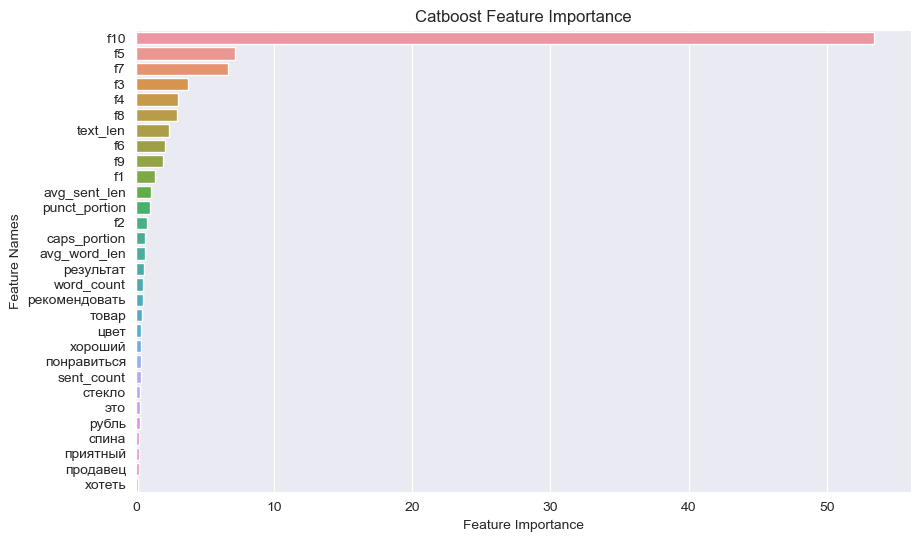

In [133]:
def plot_importance(importance, names, model_name, num_features=30):
    data = {'feature_names':names, 'feature_importance': importance}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df.sort_values(by=['feature_importance'], ascending=False).iloc[:num_features]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(f'{model_name} Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    

plot_importance(cb_bow_cv1.get_feature_importance(), X_train1.columns, 'Catboost')

**Подведем итог по моделям, к. обучались с векторизацией текстов с помощью Bag-of-words**

In [97]:
bow_final = pd.concat([
    res_df_knn_bow1, res_df_knn_bow_cv1, res_df_lr_bow1, res_df_lr_bow_cv1,
    res_df_svm_bow1, res_df_svm_bow_cv1, res_df_lgbm_bow1, res_df_lgbm_bow_cv1,
    res_df_cb_bow1, res_df_cb_bow_cv1
])
bow_final

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
knn_bow1      train      0.794   0.415  0.545     0.672    0.857   0.725   
              test       0.600   0.273  0.375     0.484    0.644   0.488   
knn_bow_cv1   train      0.826   0.230  0.360     0.544    0.774   0.611   
              test       0.766   0.218  0.340     0.510    0.703   0.518   
lr_bow1       train      0.722   0.800  0.759     0.737    0.924   0.842   
              test       0.476   0.491  0.484     0.479    0.661   0.487   
lr_bow_cv1    train      0.509   0.570  0.538     0.520    0.768   0.597   
              test       0.514   0.539  0.527     0.519    0.740   0.541   
svm_bow1      train      0.471   0.629  0.539     0.496    0.773   0.631   
              test       0.447   0.558  0.496     0.465    0.750   0.553   
svm_bow_cv1   train      0.551   0.517  0.533     0.544    0.769   0.583   
              test       0.536   0.448  0.488     0.516    0.748   0.549   
lgbm_bow1     train      1.000   0.941  0.970     0.988    1.000   1.000   
              test       0.620   0.297  0.402     0.509    0.712   0.549   
lgbm_bow_cv1  train      0.917   0.283  0.433     0.633    0.843   0.736   
              test       0.773   0.206  0.325     0.499    0.753   0.560   
cb_bow1       train      0.961   0.524  0.678     0.824    0.942   0.893   
              test       0.692   0.273  0.391     0.529    0.771   0.574   
cb_bow_cv1    train      0.852   0.192  0.314     0.506    0.811   0.669   
              test       0.756   0.188  0.301     0.471    0.775   0.568   

                                cv   train_time inference_time  
configuration set                                               
knn_bow1      train  0.48$\pm$0.06    937.17 ms            NaN  
              test   0.48$\pm$0.06          NaN      354.57 ms  
knn_bow_cv1   train  0.48$\pm$0.09    945.05 ms            NaN  
              test   0.48$\pm$0.09          NaN      399.36 ms  
lr_bow1       train  0.47$\pm$0.04    579.93 ms            NaN  
              test   0.47$\pm$0.04          NaN       13.01 ms  
lr_bow_cv1    train  0.48$\pm$0.05     72.56 ms            NaN  
              test   0.48$\pm$0.05          NaN        10.8 ms  
svm_bow1      train  0.46$\pm$0.03  32049.36 ms            NaN  
              test   0.46$\pm$0.03          NaN     2369.26 ms  
svm_bow_cv1   train   0.5$\pm$0.06   26733.5 ms            NaN  
              test    0.5$\pm$0.06          NaN     1530.67 ms  
lgbm_bow1     train  0.53$\pm$0.06    380.02 ms            NaN  
              test   0.53$\pm$0.06          NaN        26.4 ms  
lgbm_bow_cv1  train  0.51$\pm$0.07    362.88 ms            NaN  
              test   0.51$\pm$0.07          NaN       32.33 ms  
cb_bow1       train  0.56$\pm$0.08   8423.07 ms            NaN  
              test   0.56$\pm$0.08          NaN       32.68 ms  
cb_bow_cv1    train  0.46$\pm$0.09   3377.74 ms            NaN  
              test   0.46$\pm$0.09          NaN       30.58 ms

### Теперь используем TF-IDF для векторизации текстов

In [83]:
vectorizer = TfidfVectorizer(preprocessor=preprocess_text, tokenizer=word_tokenize,
                             min_df=4, token_pattern='[А-Яа-яёЁ\s]+')
tf_idf = vectorizer.fit_transform(df.clear_text)
tf_idf

<3122x1075 sparse matrix of type '<class 'numpy.float64'>'
	with 19455 stored elements in Compressed Sparse Row format>

In [84]:
tf_idf_df = pd.DataFrame(tf_idf.toarray(),
                         columns=vectorizer.get_feature_names_out(),
                         index=df.index)

**Разбиение и нормировка для случая без использования фичей punct_portion, f9, f10**

In [85]:
X_idf = pd.concat([X, tf_idf_df], axis=1)

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X_idf, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

**Разбиение и нормировка для случая с использованием фичей punct_portion, f9, f10**

In [87]:
X_idf1 = pd.concat([X1, tf_idf_df], axis=1)

In [88]:
X_train1, X_test1, y_train, y_test = train_test_split(X_idf1, y, test_size=0.2, 
                                                      random_state=42, stratify=y)

#### Обучение моделей

**KNN**

In [89]:
knn_idf1 = KNeighborsClassifier()
knn_idf1, res_df_knn_idf1 = fit_and_metrics(knn_idf1, X_train1, y_train,
                                            X_test1, y_test, 'knn_idf1',
                                            column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
knn_idf1      train      0.777   0.421  0.546     0.664    0.862   0.735   
              test       0.511   0.273  0.356     0.435    0.668   0.475   

                               cv train_time inference_time  
configuration set                                            
knn_idf1      train  0.47$\pm$0.1  951.66 ms            NaN  
              test   0.47$\pm$0.1        NaN      446.89 ms

In [90]:
params = {
    'n_neighbors': [5, 7, 17, 21],
    'weights': ('uniform', 'distance'),
    'p': (1, 2)
}
model = KNeighborsClassifier()

knn_gs_idf = grid_search_val(model, X_train1, y_train, X_test1, y_test,
                             params, column_transformer1)

Best score: 0.51247
Best params: {'n_neighbors': 17, 'p': 1, 'weights': 'uniform'}


In [91]:
knn_idf_cv1 = KNeighborsClassifier(**knn_gs_idf.best_params_)
knn_idf_cv1, res_df_knn_idf_cv1 = fit_and_metrics(knn_idf_cv1, X_train1, y_train,
                                                  X_test1, y_test, 'knn_idf_cv1',
                                                  column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
knn_idf_cv1   train      0.819   0.233  0.363     0.545    0.791   0.628   
              test       0.755   0.224  0.346     0.512    0.710   0.529   

                                cv  train_time inference_time  
configuration set                                              
knn_idf_cv1   train  0.47$\pm$0.08  8380.04 ms            NaN  
              test   0.47$\pm$0.08         NaN     2126.34 ms

**LogReg**

In [92]:
lr_idf1 = LogisticRegression(max_iter=5000, random_state=42,
                             class_weight='balanced')
lr_idf1, res_df_lr_idf1 = fit_and_metrics(lr_idf1, X_train1, y_train,
                                          X_test1, y_test, 'lr_idf1',
                                          column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
lr_idf1       train      0.626   0.742  0.679     0.646    0.875   0.729   
              test       0.489   0.533  0.510     0.497    0.711   0.545   

                                cv train_time inference_time  
configuration set                                             
lr_idf1       train  0.48$\pm$0.05  843.56 ms            NaN  
              test   0.48$\pm$0.05        NaN       17.24 ms

In [95]:
params = {'C': np.logspace(-3, 1, 15), 
          'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
model = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')

lr_gs_idf = grid_search_val(model, X_train1, y_train, X_test1, y_test,
                            params, column_transformer1)

Best score: 0.53179
Best params: {'C': 0.19306977288832497, 'solver': 'liblinear'}


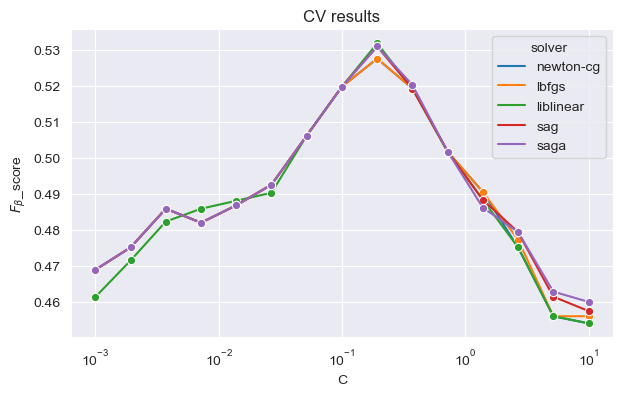

In [171]:
cv_res_df_idf = pd.DataFrame(lr_gs_idf.cv_results_['params'])
cv_res_df_idf[r'$F_\beta$_score'] = lr_gs_idf.cv_results_['mean_test_score']

fig = plt.figure(figsize=(7, 4))
sns.lineplot(data=cv_res_df_idf, x='C', y=r'$F_\beta$_score', hue='solver', marker='o')
plt.title('CV results')
plt.xscale('log')
plt.show()

In [93]:
lr_idf_cv1 = LogisticRegression(max_iter=5000, random_state=42,
                                class_weight='balanced', **lr_gs_idf.best_params_)
lr_idf_cv1, res_df_lr_idf_cv1 = fit_and_metrics(lr_idf_cv1, X_train1, y_train,
                                                X_test1, y_test, 'lr_idf_cv1',
                                                column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
lr_idf_cv1    train      0.519   0.597  0.555     0.533    0.798   0.620   
              test       0.526   0.558  0.541     0.532    0.738   0.556   

                                cv train_time inference_time  
configuration set                                             
lr_idf_cv1    train  0.48$\pm$0.05  135.96 ms            NaN  
              test   0.48$\pm$0.05        NaN       15.42 ms

In [174]:
cv_results(LogisticRegression(max_iter=5000, random_state=42, 
                              class_weight='balanced', C=0.1), 
           X_train1, y_train, column_transformer1)

CV-scores: 0.49 | 0.53 | 0.51 | 0.44 | 0.44 | 0.49 | 0.56 | 0.44 | 0.39 | 0.43
CV results on 10 folds: mean=0.4730, std=0.052


**SVM**

In [94]:
svm_idf1 = SVC(class_weight='balanced',
               probability=True, random_state=42)
svm_idf1, res_df_svm_idf1 = fit_and_metrics(svm_idf1, X_train1, y_train,
                                            X_test1, y_test, 'svm_idf1',
                                            column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
svm_idf1      train      0.566   0.614  0.589     0.575    0.851   0.700   
              test       0.515   0.515  0.515     0.515    0.758   0.538   

                                cv   train_time inference_time  
configuration set                                               
svm_idf1      train  0.48$\pm$0.03  28916.55 ms            NaN  
              test   0.48$\pm$0.03          NaN      2322.0 ms

In [95]:
params = {'C': np.logspace(-3, -1, 7), 
          'kernel': ('linear', 'rbf')}
model = SVC(class_weight='balanced', probability=True, random_state=42)

svm_gs_idf = grid_search_val(model, X_train1, y_train, X_test1, y_test,
                             params, column_transformer1)

Best score: 0.55191
Best params: {'C': 0.046415888336127774, 'kernel': 'linear'}


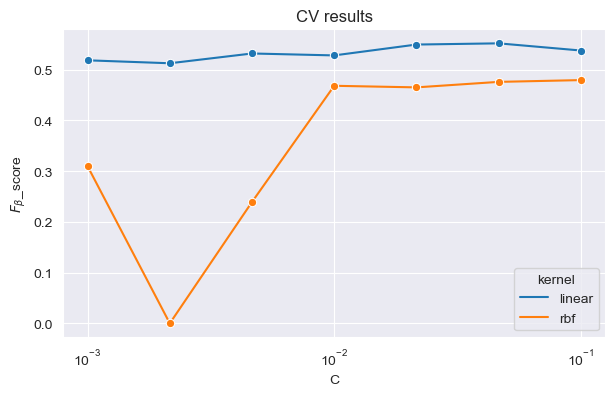

In [96]:
cv_res_df_idf = pd.DataFrame(svm_gs_idf.cv_results_['params'])
cv_res_df_idf[r'$F_\beta$_score'] = svm_gs_idf.cv_results_['mean_test_score']

fig = plt.figure(figsize=(7, 4))
sns.lineplot(data=cv_res_df_idf, x='C', y=r'$F_\beta$_score', hue='kernel', marker='o')
plt.title('CV results')
plt.xscale('log')
plt.show()

In [100]:
svm_idf_cv1 = SVC(class_weight='balanced', probability=True,
                  random_state=42, **svm_gs_idf.best_params_)
svm_idf_cv1, res_df_svm_idf_cv1 = fit_and_metrics(svm_idf_cv1, X_train1, y_train, 
                                                  X_test1, y_test, 'svm_idf_cv1',
                                                  column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
svm_idf_cv1   train      0.522   0.518  0.520     0.521    0.756   0.567   
              test       0.564   0.509  0.535     0.552    0.757   0.570   

                                cv   train_time inference_time  
configuration set                                               
svm_idf_cv1   train  0.49$\pm$0.06  24461.43 ms            NaN  
              test   0.49$\pm$0.06          NaN     1328.96 ms

**LightGBM**

In [98]:
lgbm_idf1 = LGBMClassifier(random_state=42)
lgbm_idf1, res_df_lgbm_idf1 = fit_and_metrics(lgbm_idf1, X_train1, y_train,
                                              X_test1, y_test, 'lgbm_idf1',
                                              column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
lgbm_idf1     train      0.995   0.952  0.973     0.986    1.000   0.999   
              test       0.622   0.309  0.413     0.517    0.723   0.560   

                                cv train_time inference_time  
configuration set                                             
lgbm_idf1     train  0.53$\pm$0.05  446.88 ms            NaN  
              test   0.53$\pm$0.05        NaN       24.43 ms

In [178]:
params = {
    'max_depth': range(1, 11, 2),
    'n_estimators': [50, 75, 100, 125, 150],
    'learning_rate': [0.001, 0.005, 0.01], 
    'reg_lambda': [0.001, 0.005, 0.01, 0.03]
}

model = LGBMClassifier(random_seed=42)
lgbm_gs_idf = grid_search_val(model, X_train1, y_train, X_test1, y_test,
                              params, column_transformer1)

Best score: 0.50685
Best params: {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 150, 'reg_lambda': 0.005}


In [99]:
lgbm_idf_cv1 = LGBMClassifier(random_seed=42, **{'learning_rate': 0.005, 'max_depth': 9, 'n_estimators': 150, 'reg_lambda': 0.005})
lgbm_idf_cv1, res_df_lgbm_idf_cv1 = fit_and_metrics(lgbm_idf_cv1, X_train1, y_train,
                                                    X_test1, y_test, 'lgbm_idf_cv1', 
                                                    column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
lgbm_idf_cv1  train      0.940   0.214  0.348     0.560    0.879   0.774   
              test       0.829   0.176  0.290     0.475    0.734   0.537   

                                cv train_time inference_time  
configuration set                                             
lgbm_idf_cv1  train  0.49$\pm$0.08  588.42 ms            NaN  
              test   0.49$\pm$0.08        NaN       42.21 ms

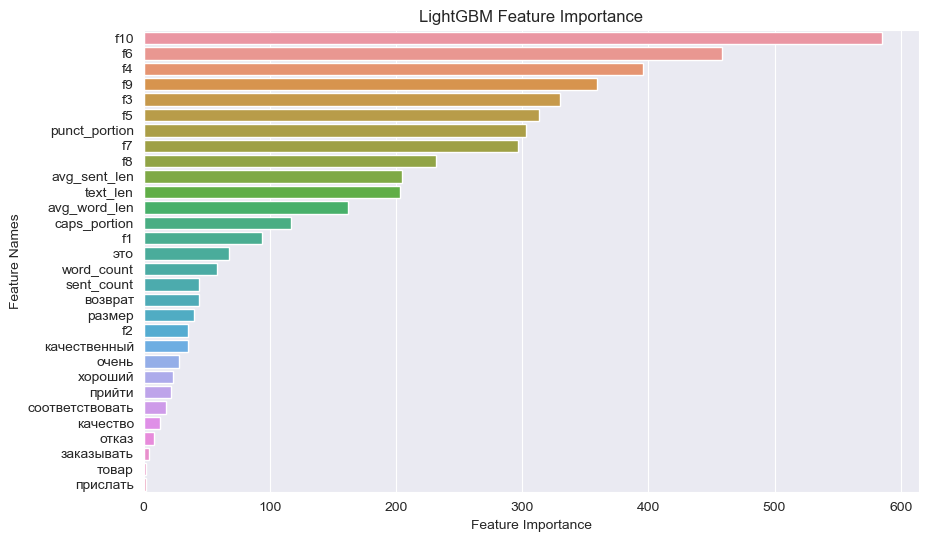

In [134]:
plot_importance(lgbm_idf_cv1.feature_importances_, X_train1.columns, 'LightGBM')

**CatBoost**

In [101]:
cb_idf1 = CatBoostClassifier(random_seed=42, logging_level='Silent')
cb_idf1, res_df_cb_idf1 = fit_and_metrics(cb_idf1, X_train1, y_train,
                                          X_test1, y_test, 'cb_idf1',
                                          column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
cb_idf1       train      0.969   0.515  0.673     0.824    0.946   0.896   
              test       0.656   0.242  0.354     0.489    0.777   0.563   

                                cv   train_time inference_time  
configuration set                                               
cb_idf1       train  0.55$\pm$0.08  14736.99 ms            NaN  
              test   0.55$\pm$0.08          NaN       27.61 ms

In [277]:
params = {
    'depth': range(1, 11, 2),
    'iterations': [50, 100, 150],
    'learning_rate': [0.0005, 0.001, 0.005, 0.01], 
    'l2_leaf_reg':[1, 2, 3]
}

model = CatBoostClassifier(random_seed=42, logging_level='Silent')
cb_gs_idf = grid_search_val(model, X_train1, y_train, X_test1, y_test,
                            params, column_transformer1)

Best score: 0.46729
Best params: {'depth': 9, 'iterations': 150, 'l2_leaf_reg': 1, 'learning_rate': 0.01}


In [102]:
cb_idf_cv1 = CatBoostClassifier(random_seed=42, logging_level='Silent',
                                **cb_gs_idf.best_params_)
cb_idf_cv1, res_df_cb_idf_cv1 = fit_and_metrics(cb_idf_cv1, X_train1, y_train,
                                                X_test1, y_test, 'cb_idf_cv1',
                                                column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
cb_idf_cv1    train      0.914   0.226  0.362     0.568    0.851   0.726   
              test       0.756   0.188  0.301     0.471    0.771   0.560   

                               cv   train_time inference_time  
configuration set                                              
cb_idf_cv1    train  0.48$\pm$0.1  13220.45 ms            NaN  
              test   0.48$\pm$0.1          NaN       28.56 ms

**Подведем итог по моделям, к. обучались с векторизацией текстов с помощью TF-IDF**

In [103]:
idf_final = pd.concat([
    res_df_knn_idf1, res_df_knn_idf_cv1, res_df_lr_idf1, res_df_lr_idf_cv1,
    res_df_svm_idf1, res_df_svm_idf_cv1, res_df_lgbm_idf1, res_df_lgbm_idf_cv1,
    res_df_cb_idf1, res_df_cb_idf_cv1
])
idf_final

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
knn_idf1      train      0.777   0.421  0.546     0.664    0.862   0.735   
              test       0.511   0.273  0.356     0.435    0.668   0.475   
knn_idf_cv1   train      0.819   0.233  0.363     0.545    0.791   0.628   
              test       0.755   0.224  0.346     0.512    0.710   0.529   
lr_idf1       train      0.626   0.742  0.679     0.646    0.875   0.729   
              test       0.489   0.533  0.510     0.497    0.711   0.545   
lr_idf_cv1    train      0.519   0.597  0.555     0.533    0.798   0.620   
              test       0.526   0.558  0.541     0.532    0.738   0.556   
svm_idf1      train      0.566   0.614  0.589     0.575    0.851   0.700   
              test       0.515   0.515  0.515     0.515    0.758   0.538   
svm_idf_cv1   train      0.522   0.518  0.520     0.521    0.756   0.567   
              test       0.564   0.509  0.535     0.552    0.757   0.570   
lgbm_idf1     train      0.995   0.952  0.973     0.986    1.000   0.999   
              test       0.622   0.309  0.413     0.517    0.723   0.560   
lgbm_idf_cv1  train      0.940   0.214  0.348     0.560    0.879   0.774   
              test       0.829   0.176  0.290     0.475    0.734   0.537   
cb_idf1       train      0.969   0.515  0.673     0.824    0.946   0.896   
              test       0.656   0.242  0.354     0.489    0.777   0.563   
cb_idf_cv1    train      0.914   0.226  0.362     0.568    0.851   0.726   
              test       0.756   0.188  0.301     0.471    0.771   0.560   

                                cv   train_time inference_time  
configuration set                                               
knn_idf1      train   0.47$\pm$0.1    951.66 ms            NaN  
              test    0.47$\pm$0.1          NaN      446.89 ms  
knn_idf_cv1   train  0.47$\pm$0.08   8380.04 ms            NaN  
              test   0.47$\pm$0.08          NaN     2126.34 ms  
lr_idf1       train  0.48$\pm$0.05    843.56 ms            NaN  
              test   0.48$\pm$0.05          NaN       17.24 ms  
lr_idf_cv1    train  0.48$\pm$0.05    135.96 ms            NaN  
              test   0.48$\pm$0.05          NaN       15.42 ms  
svm_idf1      train  0.48$\pm$0.03  28916.55 ms            NaN  
              test   0.48$\pm$0.03          NaN      2322.0 ms  
svm_idf_cv1   train  0.49$\pm$0.06  24461.43 ms            NaN  
              test   0.49$\pm$0.06          NaN     1328.96 ms  
lgbm_idf1     train  0.53$\pm$0.05    446.88 ms            NaN  
              test   0.53$\pm$0.05          NaN       24.43 ms  
lgbm_idf_cv1  train  0.49$\pm$0.08    588.42 ms            NaN  
              test   0.49$\pm$0.08          NaN       42.21 ms  
cb_idf1       train  0.55$\pm$0.08  14736.99 ms            NaN  
              test   0.55$\pm$0.08          NaN       27.61 ms  
cb_idf_cv1    train   0.48$\pm$0.1  13220.45 ms            NaN  
              test    0.48$\pm$0.1          NaN       28.56 ms

### Теперь используем W2V для векторизации текстов

In [104]:
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')
navec['товар'].shape

(300,)

In [105]:
corp_to_embeds = []
for review in df.clear_text:
    lst = [navec[w] for w in review.split() if w in navec]
    if len(lst) > 0:
        corp_to_embeds.append(np.mean(lst, axis=0))
    else:
        corp_to_embeds.append(np.zeros(300))

**Разбиение и нормировка для случая с использованием фичей punct_portion, f9, f10**

In [106]:
X_w2v = X.copy()
X_w2v['embeds'] = corp_to_embeds
embeds_df = X_w2v['embeds'].apply(pd.Series)
X_w2v = pd.concat([X_w2v, embeds_df], axis=1).drop(columns='embeds')
X_w2v.columns = X_w2v.columns.astype(str)

In [107]:
X_train, X_test, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

**Разбиение и нормировка для случая с использованием фичей punct_portion, f9, f10**

In [108]:
X_w2v1 = X1.copy()
X_w2v1['embeds'] = corp_to_embeds
embeds_df = X_w2v1['embeds'].apply(pd.Series)
X_w2v1 = pd.concat([X_w2v1, embeds_df], axis=1).drop(columns='embeds')
X_w2v1.columns = X_w2v1.columns.astype(str)

In [109]:
X_train1, X_test1, y_train, y_test = train_test_split(X_w2v1, y, test_size=0.2, 
                                                      random_state=42, stratify=y)

#### Обучение моделей

**KNN**

In [110]:
knn_w2v1 = KNeighborsClassifier()
knn_w2v1, res_df_knn_w2v1 = fit_and_metrics(knn_w2v1, X_train1, y_train,
                                            X_test1, y_test, 'knn_w2v1',
                                            column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
knn_w2v1      train      0.793   0.423  0.551     0.675    0.856   0.735   
              test       0.538   0.297  0.383     0.463    0.691   0.512   

                                cv train_time inference_time  
configuration set                                             
knn_w2v1      train  0.48$\pm$0.08  499.56 ms            NaN  
              test   0.48$\pm$0.08        NaN       313.0 ms

In [115]:
params = {
    'n_neighbors': [1, 3, 7, 12, 19],
    'weights': ('uniform', 'distance'),
    'p': (1, 2)
}
model = KNeighborsClassifier()

knn_gs_w2v = grid_search_val(model, X_train1, y_train, X_test1, y_test,
                             params, column_transformer1)

Best score: 0.49598
Best params: {'n_neighbors': 19, 'p': 2, 'weights': 'uniform'}


In [116]:
knn_w2v_cv1 = KNeighborsClassifier(**knn_gs_w2v.best_params_)
knn_w2v_cv1, res_df_knn_w2v_cv1 = fit_and_metrics(knn_w2v_cv1, X_train1, y_train,
                                                  X_test1, y_test, 'knn_w2v_cv1',
                                                  column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
knn_w2v_cv1   train      0.809   0.250  0.382     0.559    0.778   0.619   
              test       0.712   0.224  0.341     0.496    0.728   0.533   

                                cv train_time inference_time  
configuration set                                             
knn_w2v_cv1   train  0.48$\pm$0.09   508.1 ms            NaN  
              test   0.48$\pm$0.09        NaN      272.03 ms

**LogReg**

In [117]:
lr_w2v1 = LogisticRegression(max_iter=5000, random_state=42,
                             class_weight='balanced')
lr_w2v1, res_df_lr_w2v1 = fit_and_metrics(lr_w2v1, X_train1, y_train,
                                          X_test1, y_test, 'lr_w2v1',
                                          column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
lr_w2v1       train      0.525   0.689  0.596     0.552    0.819   0.653   
              test       0.401   0.515  0.451     0.420    0.689   0.502   

                                cv train_time inference_time  
configuration set                                             
lr_w2v1       train  0.44$\pm$0.03  199.62 ms            NaN  
              test   0.44$\pm$0.03        NaN        5.57 ms

In [113]:
params = {'C': np.logspace(-3, 1, 50), 
          'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
model = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')

lr_gs_w2v = grid_search_val(model, X_train1, y_train, X_test1, y_test,
                            params, column_transformer1)

Best score: 0.50167
Best params: {'C': 0.0021209508879201904, 'solver': 'liblinear'}


In [118]:
lr_w2v_cv1 = LogisticRegression(max_iter=5000, random_state=42, 
                               class_weight='balanced', **lr_gs_w2v.best_params_)
lr_w2v_cv1, res_df_lr_w2v_cv1 = fit_and_metrics(lr_w2v_cv1, X_train1, y_train, 
                                                X_test1, y_test, 'lr_w2v_cv1', 
                                                column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
lr_w2v_cv1    train      0.474   0.532  0.501     0.484    0.730   0.545   
              test       0.492   0.545  0.517     0.502    0.732   0.518   

                                cv train_time inference_time  
configuration set                                             
lr_w2v_cv1    train  0.47$\pm$0.05   86.47 ms            NaN  
              test   0.47$\pm$0.05        NaN        5.72 ms

**SVM**

In [119]:
svm_w2v1 = SVC(class_weight='balanced', probability=True, random_state=42)
svm_w2v1, res_df_svm_w2v1 = fit_and_metrics(svm_w2v1, X_train1, y_train,
                                            X_test1, y_test, 'svm_w2v1',
                                            column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
svm_w2v1      train      0.667   0.727  0.696     0.678    0.890   0.764   
              test       0.491   0.497  0.494     0.492    0.748   0.523   

                                cv  train_time inference_time  
configuration set                                              
svm_w2v1      train  0.48$\pm$0.04  9615.43 ms            NaN  
              test   0.48$\pm$0.04         NaN       737.8 ms

In [116]:
params = {'C': np.logspace(-3, 1, 7), 
          'kernel': ('linear', 'rbf')}
model = SVC(class_weight='balanced', probability=True, random_state=42)

svm_gs_w2v = grid_search_val(model, X_train1, y_train, X_test1, y_test,
                             params, column_transformer1)

Best score: 0.53405
Best params: {'C': 0.004641588833612777, 'kernel': 'linear'}


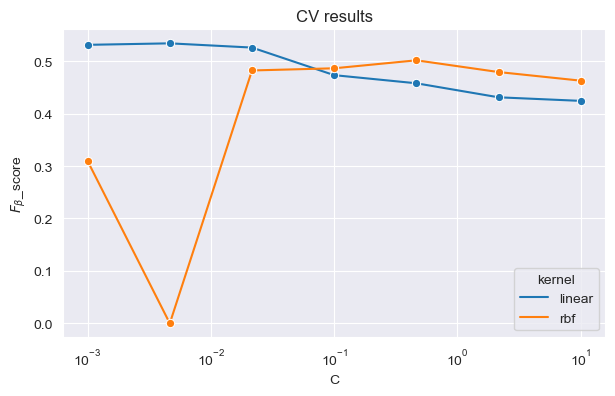

In [234]:
cv_res_df_w2v = pd.DataFrame(svm_gs_w2v.cv_results_['params'])
cv_res_df_w2v[r'$F_\beta$_score'] = svm_gs_w2v.cv_results_['mean_test_score']

fig = plt.figure(figsize=(7, 4))
sns.lineplot(data=cv_res_df_w2v, x='C', y=r'$F_\beta$_score', hue='kernel', marker='o')
plt.title('CV results')
plt.xscale('log')
plt.show()

In [120]:
svm_w2v_cv1 = SVC(class_weight='balanced', probability=True,
                  random_state=42, **svm_gs_w2v.best_params_)
svm_w2v_cv1, res_df_svm_w2v_cv1 = fit_and_metrics(svm_w2v_cv1, X_train1, y_train, 
                                                  X_test1, y_test, 'svm_w2v_cv1',
                                                  column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
svm_w2v_cv1   train      0.510   0.482  0.496     0.504    0.735   0.535   
              test       0.548   0.485  0.514     0.534    0.753   0.540   

                                cv  train_time inference_time  
configuration set                                              
svm_w2v_cv1   train  0.48$\pm$0.05  6665.03 ms            NaN  
              test   0.48$\pm$0.05         NaN      303.03 ms

**LightGBM**

In [121]:
lgbm_w2v1 = LGBMClassifier(random_state=42)
lgbm_w2v1, res_df_lgbm_w2v1 = fit_and_metrics(lgbm_w2v1, X_train1, y_train,
                                              X_test1, y_test, 'lgbm_w2v1',
                                              column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
lgbm_w2v1     train      1.000   1.000  1.000     1.000    1.000   1.000   
              test       0.607   0.206  0.308     0.437    0.719   0.518   

                                cv  train_time inference_time  
configuration set                                              
lgbm_w2v1     train  0.51$\pm$0.08  1819.77 ms            NaN  
              test   0.51$\pm$0.08         NaN       14.59 ms

In [248]:
params = {
    'max_depth': range(1, 11, 2),
    'n_estimators': [50, 75, 100, 125, 150],
    'learning_rate': [0.001, 0.005, 0.01], 
    'reg_lambda': [0.001, 0.005, 0.01, 0.03]
}

model = LGBMClassifier(random_seed=42)
lgbm_gs_w2v = grid_search_val(model, X_train1, y_train, X_test1, y_test,
                              params, column_transformer1)

Best score: 0.45455
Best params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 125, 'reg_lambda': 0.001}


In [122]:
lgbm_w2v_cv1 = LGBMClassifier(random_seed=42, **lgbm_gs_w2v.best_params_)
lgbm_w2v_cv1, res_df_lgbm_w2v_cv1 = fit_and_metrics(lgbm_w2v_cv1, X_train1, y_train,
                                                    X_test1, y_test, 'lgbm_w2v_cv1',
                                                    column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
lgbm_w2v_cv1  train      0.939   0.186  0.311     0.519    0.789   0.653   
              test       0.818   0.164  0.273     0.455    0.758   0.555   

                                cv train_time inference_time  
configuration set                                             
lgbm_w2v_cv1  train  0.46$\pm$0.06   682.9 ms            NaN  
              test   0.46$\pm$0.06        NaN       14.96 ms

**CatBoost**

In [123]:
cb_w2v1 = CatBoostClassifier(random_seed=42, logging_level='Silent')
cb_w2v1, res_df_cb_w2v1 = fit_and_metrics(cb_w2v1, X_train1, y_train, 
                                          X_test1, y_test, 'cb_w2v1',
                                          column_transformer1, False)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
cb_w2v1       train      0.998   0.911  0.952     0.979    1.000   0.999   
              test       0.712   0.224  0.341     0.496    0.713   0.509   

                      train_time inference_time  
configuration set                                
cb_w2v1       train  39248.87 ms            NaN  
              test           NaN       17.35 ms

In [262]:
params = {
    'depth': range(1, 11, 2),
    'iterations': [50, 100, 150],
    'learning_rate': [0.0005, 0.001, 0.005, 0.01], 
    'l2_leaf_reg':[1, 2, 3]
}

model = CatBoostClassifier(random_seed=42, logging_level='Silent')
cb_gs_w2v = grid_search_val(model, X_train1, y_train, X_test1, y_test,
                            params, column_transformer1)

Best score: 0.44850
Best params: {'depth': 3, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.005}


In [124]:
cb_w2v_cv1 = CatBoostClassifier(random_seed=42, logging_level='Silent',
                                **cb_gs_w2v.best_params_)
cb_w2v_cv1, res_df_cb_w2v_cv1 = fit_and_metrics(cb_w2v_cv1, X_train1, y_train,
                                                X_test1, y_test, 'cb_w2v_cv1',
                                                column_transformer1)

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
cb_w2v_cv1    train      0.890   0.171  0.287     0.484    0.747   0.576   
              test       0.794   0.164  0.271     0.449    0.714   0.497   

                                cv  train_time inference_time  
configuration set                                              
cb_w2v_cv1    train  0.45$\pm$0.08  1128.69 ms            NaN  
              test   0.45$\pm$0.08         NaN       12.03 ms

**Подведем итог по моделям, к. обучались с векторизацией текстов с помощью Word2Vec**

In [125]:
w2v_final = pd.concat([
    res_df_knn_w2v1, res_df_knn_w2v_cv1, res_df_lr_w2v1, res_df_lr_w2v_cv1,
    res_df_svm_w2v1, res_df_svm_w2v_cv1, res_df_lgbm_w2v1, res_df_lgbm_w2v_cv1,
    res_df_cb_w2v1, res_df_cb_w2v_cv1
])
w2v_final

precision  recall     F1  F$\beta$  roc_auc  pr_auc  \
configuration set                                                          
knn_w2v1      train      0.793   0.423  0.551     0.675    0.856   0.735   
              test       0.538   0.297  0.383     0.463    0.691   0.512   
knn_w2v_cv1   train      0.809   0.250  0.382     0.559    0.778   0.619   
              test       0.712   0.224  0.341     0.496    0.728   0.533   
lr_w2v1       train      0.525   0.689  0.596     0.552    0.819   0.653   
              test       0.401   0.515  0.451     0.420    0.689   0.502   
lr_w2v_cv1    train      0.474   0.532  0.501     0.484    0.730   0.545   
              test       0.492   0.545  0.517     0.502    0.732   0.518   
svm_w2v1      train      0.667   0.727  0.696     0.678    0.890   0.764   
              test       0.491   0.497  0.494     0.492    0.748   0.523   
svm_w2v_cv1   train      0.510   0.482  0.496     0.504    0.735   0.535   
              test       0.548   0.485  0.514     0.534    0.753   0.540   
lgbm_w2v1     train      1.000   1.000  1.000     1.000    1.000   1.000   
              test       0.607   0.206  0.308     0.437    0.719   0.518   
lgbm_w2v_cv1  train      0.939   0.186  0.311     0.519    0.789   0.653   
              test       0.818   0.164  0.273     0.455    0.758   0.555   
cb_w2v1       train      0.998   0.911  0.952     0.979    1.000   0.999   
              test       0.712   0.224  0.341     0.496    0.713   0.509   
cb_w2v_cv1    train      0.890   0.171  0.287     0.484    0.747   0.576   
              test       0.794   0.164  0.271     0.449    0.714   0.497   

                                cv   train_time inference_time  
configuration set                                               
knn_w2v1      train  0.48$\pm$0.08    499.56 ms            NaN  
              test   0.48$\pm$0.08          NaN       313.0 ms  
knn_w2v_cv1   train  0.48$\pm$0.09     508.1 ms            NaN  
              test   0.48$\pm$0.09          NaN      272.03 ms  
lr_w2v1       train  0.44$\pm$0.03    199.62 ms            NaN  
              test   0.44$\pm$0.03          NaN        5.57 ms  
lr_w2v_cv1    train  0.47$\pm$0.05     86.47 ms            NaN  
              test   0.47$\pm$0.05          NaN        5.72 ms  
svm_w2v1      train  0.48$\pm$0.04   9615.43 ms            NaN  
              test   0.48$\pm$0.04          NaN       737.8 ms  
svm_w2v_cv1   train  0.48$\pm$0.05   6665.03 ms            NaN  
              test   0.48$\pm$0.05          NaN      303.03 ms  
lgbm_w2v1     train  0.51$\pm$0.08   1819.77 ms            NaN  
              test   0.51$\pm$0.08          NaN       14.59 ms  
lgbm_w2v_cv1  train  0.46$\pm$0.06     682.9 ms            NaN  
              test   0.46$\pm$0.06          NaN       14.96 ms  
cb_w2v1       train            NaN  39248.87 ms            NaN  
              test             NaN          NaN       17.35 ms  
cb_w2v_cv1    train  0.45$\pm$0.08   1128.69 ms            NaN  
              test   0.45$\pm$0.08          NaN       12.03 ms

## Проанализируем полученные модели

In [6]:
compare_df = pd.read_csv('wb_res_df_l6_1.csv', index_col=['embeds', 'configuration', 'set'])

In [7]:
pd.set_option('display.max_rows', 70)

In [140]:
compare_df = pd.concat([no_text_final, bow_final, idf_final, w2v_final],
                       keys=['no_text', 'bow', 'idf', 'w2v'],
                       names=['embeds'] + no_text_final.index.names)
compare_df

precision  recall     F1  F$\beta$  roc_auc  \
embeds  configuration   set                                                  
no_text dummy_baseline  train      0.264   1.000  0.418     0.310    0.500   
                        test       0.264   1.000  0.418     0.310    0.500   
        simple_baseline train      0.448   0.633  0.525     0.476    0.727   
                        test       0.422   0.558  0.480     0.444    0.732   
        lr_no_text      train      0.438   0.555  0.490     0.457    0.708   
                        test       0.456   0.570  0.507     0.475    0.742   
        lr_no_text_cv   train      0.439   0.556  0.491     0.458    0.709   
                        test       0.468   0.576  0.516     0.486    0.745   
        lr_no_text1     train      0.462   0.545  0.500     0.477    0.723   
                        test       0.484   0.564  0.521     0.498    0.739   
bow     knn_bow1        train      0.794   0.415  0.545     0.672    0.857   
                        test       0.600   0.273  0.375     0.484    0.644   
        knn_bow_cv1     train      0.826   0.230  0.360     0.544    0.774   
                        test       0.766   0.218  0.340     0.510    0.703   
        lr_bow1         train      0.722   0.800  0.759     0.737    0.924   
                        test       0.476   0.491  0.484     0.479    0.661   
        lr_bow_cv1      train      0.509   0.570  0.538     0.520    0.768   
                        test       0.514   0.539  0.527     0.519    0.740   
        svm_bow1        train      0.471   0.629  0.539     0.496    0.773   
                        test       0.447   0.558  0.496     0.465    0.750   
        svm_bow_cv1     train      0.551   0.517  0.533     0.544    0.769   
                        test       0.536   0.448  0.488     0.516    0.748   
        lgbm_bow1       train      1.000   0.941  0.970     0.988    1.000   
                        test       0.620   0.297  0.402     0.509    0.712   
        lgbm_bow_cv1    train      0.917   0.283  0.433     0.633    0.843   
                        test       0.773   0.206  0.325     0.499    0.753   
        cb_bow1         train      0.961   0.524  0.678     0.824    0.942   
                        test       0.692   0.273  0.391     0.529    0.771   
        cb_bow_cv1      train      0.852   0.192  0.314     0.506    0.811   
                        test       0.756   0.188  0.301     0.471    0.775   
idf     knn_idf1        train      0.777   0.421  0.546     0.664    0.862   
                        test       0.511   0.273  0.356     0.435    0.668   
        knn_idf_cv1     train      0.819   0.233  0.363     0.545    0.791   
                        test       0.755   0.224  0.346     0.512    0.710   
        lr_idf1         train      0.626   0.742  0.679     0.646    0.875   
                        test       0.489   0.533  0.510     0.497    0.711   
        lr_idf_cv1      train      0.519   0.597  0.555     0.533    0.798   
                        test       0.526   0.558  0.541     0.532    0.738   
        svm_idf1        train      0.566   0.614  0.589     0.575    0.851   
                        test       0.515   0.515  0.515     0.515    0.758   
        svm_idf_cv1     train      0.522   0.518  0.520     0.521    0.756   
                        test       0.564   0.509  0.535     0.552    0.757   
        lgbm_idf1       train      0.995   0.952  0.973     0.986    1.000   
                        test       0.622   0.309  0.413     0.517    0.723   
        lgbm_idf_cv1    train      0.940   0.214  0.348     0.560    0.879   
                        test       0.829   0.176  0.290     0.475    0.734   
        cb_idf1         train      0.969   0.515  0.673     0.824    0.946   
                        test       0.656   0.242  0.354     0.489    0.777   
        cb_idf_cv1      train      0.914   0.226  0.362     0.568    0.851   
                        test       0.756   0.188  0.3

In [130]:
# compare_df.to_csv('wb_res_df_l6_1.csv')

In [9]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
compare_df.drop(('no_text', 'lr_no_text'), axis=0, inplace=True)
compare_df.drop(('no_text', 'lr_no_text_cv'), axis=0, inplace=True)

compare_df.drop(('bow', 'knn_bow1'), axis=0, inplace=True)
compare_df.drop(('bow', 'lr_bow1'), axis=0, inplace=True)
compare_df.drop(('bow', 'cb_bow1'), axis=0, inplace=True) 
compare_df.drop(('bow', 'lgbm_bow1'), axis=0, inplace=True)
compare_df.drop(('bow', 'lgbm_bow_cv1'), axis=0, inplace=True)

compare_df.drop(('idf', 'knn_idf1'), axis=0, inplace=True)
compare_df.drop(('idf', 'lr_idf1'), axis=0, inplace=True)
compare_df.drop(('idf', 'svm_idf1'), axis=0, inplace=True)
compare_df.drop(('idf', 'lgbm_idf1'), axis=0, inplace=True)
compare_df.drop(('idf', 'lgbm_idf_cv1'), axis=0, inplace=True)
compare_df.drop(('idf', 'cb_idf1'), axis=0, inplace=True)
compare_df.drop(('idf', 'cb_idf_cv1'), axis=0, inplace=True)

compare_df.drop(('w2v', 'knn_w2v1'), axis=0, inplace=True)
compare_df.drop(('w2v', 'lr_w2v1'), axis=0, inplace=True)
compare_df.drop(('w2v', 'svm_w2v1'), axis=0, inplace=True)
compare_df.drop(('w2v', 'lgbm_w2v1'), axis=0, inplace=True)
compare_df.drop(('w2v', 'cb_w2v1'), axis=0, inplace=True)

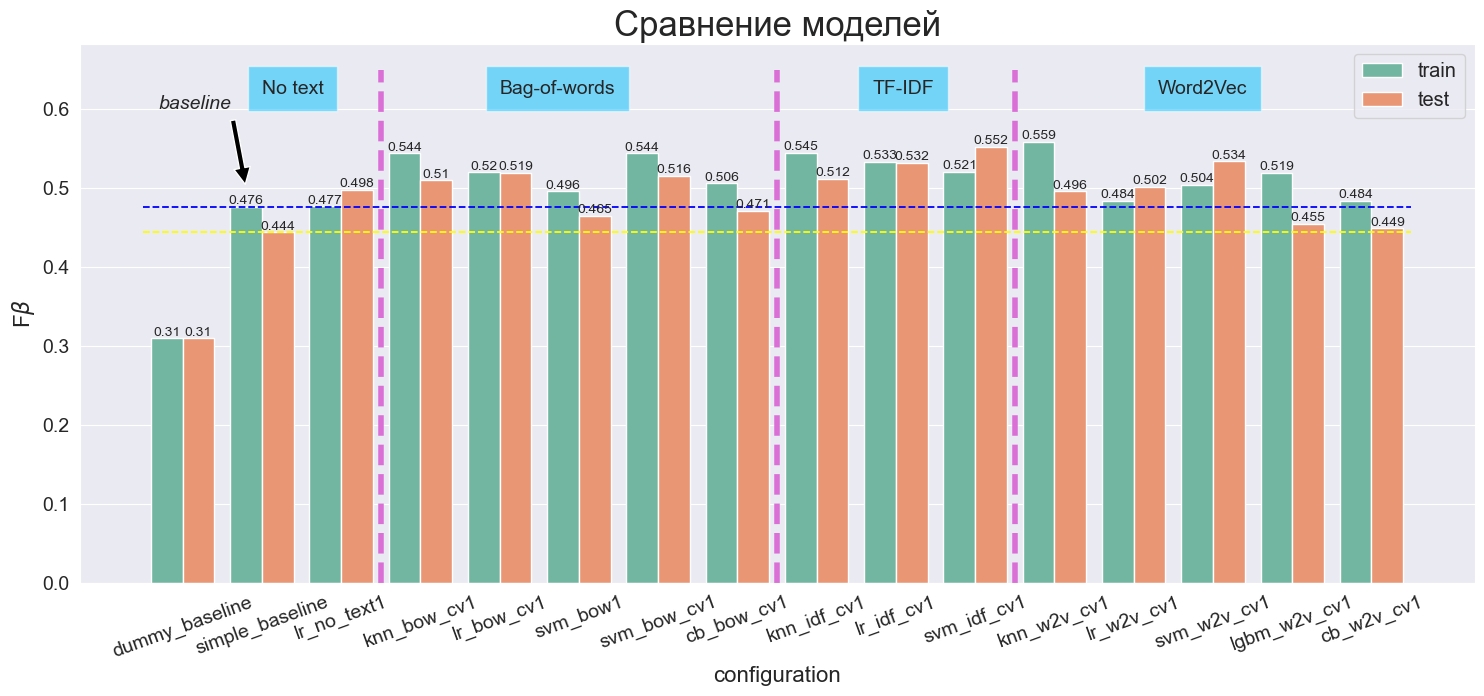

In [10]:
plt.figure(figsize=(18, 7))
b = sns.barplot(data=compare_df.reset_index(level=['configuration', 'set']),
                x='configuration', y=r'F$\beta$', hue='set', palette='Set2')
plt.vlines(x=[2.5, 7.5, 10.5], ymin=[0, 0, 0], ymax=[0.65, 0.65, 0.65],
           color='orchid', ls='--', lw=4)
plt.hlines(y=[0.476, 0.444], xmin=-0.5, xmax=15.5,
           colors=['blue', 'yellow'], ls='--', lw=1.3)
b.axes.set_title("Сравнение моделей", fontsize=25)
b.set_xlabel("configuration", fontsize=16)
b.set_ylabel(r'F$\beta$', fontsize=16)
b.tick_params(labelsize=14)
b.bar_label(b.containers[0])
b.bar_label(b.containers[1])
b.text(1, 0.62, 'No text', fontsize=14,
       bbox={'facecolor': 'deepskyblue', 'alpha': 0.5, 'pad': 10})
b.text(4, 0.62, 'Bag-of-words', fontsize=14, 
       bbox={'facecolor': 'deepskyblue', 'alpha': 0.5, 'pad': 10})
b.text(8.7, 0.62, 'TF-IDF', fontsize=14, 
       bbox={'facecolor': 'deepskyblue', 'alpha': 0.5, 'pad': 10})
b.text(12.3, 0.62, 'Word2Vec', fontsize=14, 
       bbox={'facecolor': 'deepskyblue', 'alpha': 0.5, 'pad': 10})
b.annotate('baseline', xy=(0.8, 0.5), xytext=(-0.3, 0.6), style='italic',
            arrowprops=dict(facecolor='black', shrink=0.05), fontsize=14)
# for i in [3, 4, 5, 6]:
#     b.patches[i].set(edgecolor='red', linewidth=3)
# for i in [10, 11, 12, 13]:
#     b.patches[i].set(edgecolor='red', linewidth=3)
plt.xticks(rotation=20)
plt.legend(fontsize='x-large', title_fontsize='40')
plt.show()

In [11]:
compare_df_plt = compare_df.reset_index(level=['configuration', 'set'])
compare_df_plt = compare_df_plt[compare_df_plt.set == 'test']
compare_df_plt['inference_time_num'] = compare_df_plt['inference_time'].apply(lambda x: x.split()[0])
compare_df_plt['inference_time_num'] = compare_df_plt['inference_time_num'].astype(float)
compare_df_plt['cv_num'] = compare_df_plt['cv'].apply(lambda x: x.split('$\pm$')[0])
compare_df_plt['cv_num'] = compare_df_plt['cv_num'].astype(float)
fig = px.scatter(
    data_frame=compare_df_plt, x=r'F$\beta$', y='precision',
    text='configuration', size='inference_time_num', color='cv_num',
    labels={r'F$\beta$': r'$F\beta$', 'cv_num': 'cv', 'inference_time_num': 'inference_time'}
)

fig.update_traces(textposition='top center')

fig.update_layout(
    autosize=False,
    height=600,
    width=1000,
    title={
        'text': '<b>График F_beta vs precision</b>',
        'font': {'size': 25},
        'x': 0.5
    }
)
fig.show()

In [12]:
compare_df_plt = compare_df.reset_index()
compare_df_plt_train = compare_df_plt[compare_df_plt.set == 'train'].set_index(keys=['embeds', 'configuration'])
compare_df_plt_train = compare_df_plt_train.drop(columns=['set', 'inference_time'])
compare_df_plt_test = compare_df_plt[compare_df_plt.set == 'test'].set_index(keys=['embeds', 'configuration'])
compare_df_plt_test = compare_df_plt_test.drop(columns=['set', 'train_time', 'cv'])

In [13]:
compare_df_plt = compare_df_plt_train.join(compare_df_plt_test, lsuffix='_train', rsuffix='_test').reset_index()
compare_df_plt = compare_df_plt
compare_df_plt['inference_time_num'] = compare_df_plt['inference_time'].apply(lambda x: x.split()[0])
compare_df_plt['inference_time_num'] = compare_df_plt['inference_time_num'].astype(float)
compare_df_plt['cv_num'] = compare_df_plt['cv'].apply(lambda x: x.split('$\pm$')[0])
compare_df_plt['cv_num'] = compare_df_plt['cv_num'].astype(float)
fig = px.scatter(
    data_frame=compare_df_plt, x=r'F$\beta$_train', y=r'F$\beta$_test',
    text='configuration', size='inference_time_num', color='precision_test',
    labels={
        r'F$\beta$_train': r'$F\beta-train$',
        r'F$\beta$_test': r'$F\beta-test$',
        'cv_num': 'cv',
        'inference_time_num': 'inference_time'
    }
)

fig.update_traces(textposition='top center')

fig.update_layout(
    autosize=False,
    height=600,
    width=1000,
    title={
        'text': '<b>График F_beta train vs F_beta test</b>',
        'font': {'size': 25},
        'x': 0.5
    }
)
fig.show()